# Weak/Integral SINDy Feature Overview
It is often difficult to identify dynamical systems in the presence of substantial noise. Towards that end, a number of publications have used SINDy to identify the weak-formulation (integral formulation) of the system of ODEs or PDEs. This allows one to avoid taking high-order derivatives of noisy data (high-order derivatives of noisy data will amplify the noise). 

This notebook provides a simple overview of the weak form PDE functionality of PySINDy, following the examples in the PDE-FIND paper (Rudy, Samuel H., Steven L. Brunton, Joshua L. Proctor, and J. Nathan Kutz. "Data-driven discovery of partial differential equations." Science Advances 3, no. 4 (2017): e1602614) and Reinbold, P. A., Gurevich, D. R., & Grigoriev, R. O. (2020). Using noisy or incomplete data to discover models of spatiotemporal dynamics. Physical Review E, 101(1), 010203. Jupyter notebook written by Alan Kaptanoglu and Zachary Nicolaou.

As of release 1.7, the weak formulation is vectorized and much faster to compute. The "num_pts_per_domain" variable is now deprecated. It can still be passed to the WeakPDELibrary to avoid breaking old code, but it will raise a DeprecationWarning and do nothing to the library.

An interactive version of this notebook is available on binder
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.7.3?filepath=examples/12_weakform_SINDy_examples.ipynb)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from pysindy.utils.odes import lorenz

import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

# integration keywords for solve_ivp, typically needed for chaotic systems
integrator_keywords = {}
integrator_keywords["rtol"] = 1e-12
integrator_keywords["method"] = "LSODA"
integrator_keywords["atol"] = 1e-12

# Test weak form ODE functionality on Lorenz equation

In [2]:
# Generate measurement data
dt = 0.002
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
u0_train = [-8, 8, 27]
u_train = solve_ivp(
    lorenz, t_train_span, u0_train, t_eval=t_train, **integrator_keywords
).y.T

# Instantiate and fit the SINDy model with u_dot
u_dot = ps.FiniteDifference()._differentiate(u_train, t=dt)
model = ps.SINDy()
model.fit(u_train, x_dot=u_dot, t=dt)
model.print()

# Define weak form ODE library
# defaults to derivative_order = 0 if not specified,
# and if spatial_grid is not specified, defaults to None,
# which allows weak form ODEs.
library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]
ode_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    spatiotemporal_grid=t_train,
    is_uniform=True,
    K=100,
)

# Instantiate and fit the SINDy model with the integral of u_dot
optimizer = ps.SR3(
    threshold=0.05, thresholder="l1", max_iter=1000, normalize_columns=True, tol=1e-1
)
model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
model.fit(u_train)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1
(x0)' = -9.984 x0 + 9.985 x1
(x1)' = 27.975 x0 + -0.988 x1 + -0.999 x0x2
(x2)' = -2.663 x2 + 0.999 x0x1


Performance should improve as the number of sub-domain integrations points increases (numerically approximating the integrals better and better) and number of sub-domains increases (more points for regression). Let's use some noisy Lorenz data and investigate.

In [3]:
%%time
# Generate measurement data
dt = 0.001
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
u0_train = [-8, 8, 27]
u0_test = [8, 7, 15]
u_train = solve_ivp(
    lorenz, t_train_span, u0_train, t_eval=t_train, **integrator_keywords
).y.T
u_test = solve_ivp(
    lorenz, t_train_span, u0_test, t_eval=t_train, **integrator_keywords
).y.T
rmse = mean_squared_error(u_train, np.zeros((u_train).shape), squared=False)
u_dot_clean = ps.FiniteDifference()._differentiate(u_test, t=dt)
u_clean = u_test
u_train = u_train + np.random.normal(0, rmse / 5.0, u_train.shape)  # Add 20% noise
rmse = mean_squared_error(u_test, np.zeros(u_test.shape), squared=False)
u_test = u_test + np.random.normal(0, rmse / 5.0, u_test.shape)  # Add 20% noise
u_dot = ps.FiniteDifference()._differentiate(u_test, t=dt)

# Same library terms as before
library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]

# Scan over the number of integration points and the number of subdomains
n = 10
errs = np.zeros((n))
K_scan = np.linspace(20, 2000, n, dtype=int)
for i, K in enumerate(K_scan):
    ode_lib = ps.WeakPDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        spatiotemporal_grid=t_train,
        include_bias=True,
        is_uniform=True,
        K=K,
    )
    opt = ps.SR3(
        threshold=0.05,
        thresholder="l0",
        max_iter=1000,
        normalize_columns=True,
        tol=1e-1,
    )
    u_dot_train_integral = ode_lib.convert_u_dot_integral(u_train)

    # Instantiate and fit the SINDy model with the integral of u_dot
    model = ps.SINDy(feature_library=ode_lib, optimizer=opt)
    model.fit(u_train)
    errs[i] = np.sqrt(
        (
            np.sum((u_dot_train_integral - opt.Theta_ @ opt.coef_.T) ** 2)
            / np.sum(u_dot_train_integral**2)
        )
        / u_dot_train_integral.shape[0]
    )
    print(f"i={i}, K={K} :\t ", end="")
    model.print()

i=0, K=20 :	 (x0)' = 0.587 1 + -9.426 x0 + 10.078 x1 + -0.040 x2 + 0.007 x0x0 + 0.003 x1x1 + 0.001 x2x2 + -0.013 x0x1 + -0.007 x0x2 + -0.019 x1x2
(x1)' = 1.586 1 + 28.232 x0 + -0.732 x1 + -0.306 x2 + -0.105 x0x0 + 0.019 x1x1 + 0.012 x2x2 + 0.046 x0x1 + -1.003 x0x2 + -0.013 x1x2
(x2)' = -5.513 1 + 0.152 x0 + -0.196 x1 + -1.921 x2 + 0.222 x0x0 + 0.066 x1x1 + -0.030 x2x2 + 0.759 x0x1 + 0.009 x1x2
i=1, K=240 :	 (x0)' = -3.682 1 + -11.109 x0 + 10.777 x1 + 0.466 x2 + 0.086 x0x0 + 0.007 x1x1 + -0.014 x2x2 + -0.071 x0x1 + 0.036 x0x2 + -0.028 x1x2
(x1)' = 10.041 1 + 28.882 x0 + -1.176 x1 + -1.000 x2 + -0.130 x0x0 + -0.062 x1x1 + 0.028 x2x2 + 0.167 x0x1 + -1.023 x0x2 + -0.003 x1x2
(x2)' = -3.680 1 + -0.878 x0 + 0.297 x1 + -2.146 x2 + 0.249 x0x0 + 0.054 x1x1 + -0.024 x2x2 + 0.751 x0x1 + 0.028 x0x2 + -0.004 x1x2
i=2, K=460 :	 (x0)' = -6.337 1 + -11.300 x0 + 10.826 x1 + 0.753 x2 + 0.132 x0x0 + 0.021 x1x1 + -0.023 x2x2 + -0.119 x0x1 + 0.040 x0x2 + -0.027 x1x2
(x1)' = 15.243 1 + 29.923 x0 + -1.485 x1

In [4]:
%%time
# Generate measurement data
dt = 0.001
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
u0_train = [-8, 8, 27]
u0_test = [8, 7, 15]
u_train = solve_ivp(
    lorenz, t_train_span, u0_train, t_eval=t_train, **integrator_keywords
).y.T
u_test = solve_ivp(
    lorenz, t_train_span, u0_test, t_eval=t_train, **integrator_keywords
).y.T
rmse = mean_squared_error(u_train, np.zeros((u_train).shape), squared=False)
u_dot_clean = ps.FiniteDifference()._differentiate(u_test, t=dt)
u_clean = u_test
u_train = u_train + np.random.normal(0, rmse / 5.0, u_train.shape)  # Add 20% noise
rmse = mean_squared_error(u_test, np.zeros(u_test.shape), squared=False)
u_test = u_test + np.random.normal(0, rmse / 5.0, u_test.shape)  # Add 20% noise
u_dot = ps.FiniteDifference()._differentiate(u_test, t=dt)

# Same library terms as before
library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]

# Scan over the number of integration points and the number of subdomains
n = 10
errs = np.zeros((n))
K_scan = np.linspace(20, 2000, n, dtype=int)
for i, K in enumerate(K_scan):
    ode_lib = ps.WeakPDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        spatiotemporal_grid=t_train,
        include_bias=True,
        is_uniform=True,
        K=K,
    )
    opt = ps.SR3(
        threshold=0.05,
        thresholder="l0",
        max_iter=1000,
        normalize_columns=True,
        tol=1e-3,
    )
    u_dot_train_integral = ode_lib.convert_u_dot_integral(u_train)

    # Instantiate and fit the SINDy model with the integral of u_dot
    model = ps.SINDy(feature_library=ode_lib, optimizer=opt)
    model.fit(u_train)
    errs[i] = np.sqrt(
        (
            np.sum((u_dot_train_integral - opt.Theta_ @ opt.coef_.T) ** 2)
            / np.sum(u_dot_train_integral**2)
        )
        / u_dot_train_integral.shape[0]
    )
    print(f"i={i}, K={K} :\t ", end="")
    model.print()

i=0, K=20 :	 (x0)' = -44.122 1 + -15.011 x0 + 10.793 x1 + 5.147 x2 + 0.850 x0x0 + 0.128 x1x1 + -0.160 x2x2 + -0.726 x0x1 + 0.125 x0x2 + 0.019 x1x2
(x1)' = 13.815 1 + 29.991 x0 + -0.588 x1 + -0.957 x2 + 0.058 x0x0 + -0.020 x1x1 + 0.011 x2x2 + -0.008 x0x1 + -1.043 x0x2 + -0.038 x1x2
(x2)' = -13.737 1 + 0.556 x0 + -0.260 x1 + -0.678 x2 + 0.303 x0x0 + 0.038 x1x1 + -0.067 x2x2 + 0.770 x0x1 + -0.021 x0x2 + 0.012 x1x2
i=1, K=240 :	 (x0)' = -31.843 1 + -12.345 x0 + 10.631 x1 + 3.746 x2 + 0.598 x0x0 + 0.078 x1x1 + -0.115 x2x2 + -0.498 x0x1 + 0.053 x0x2 + 0.003 x1x2
(x1)' = 9.293 1 + 29.028 x0 + -1.593 x1 + -0.495 x2 + 0.016 x0x0 + -0.113 x1x1 + 0.003 x2x2 + 0.137 x0x1 + -1.032 x0x2 + 0.022 x1x2
(x2)' = -12.294 1 + 0.461 x0 + -1.078 x1 + -0.997 x2 + 0.286 x0x0 + -0.017 x1x1 + -0.055 x2x2 + 0.836 x0x1 + -0.021 x0x2 + 0.045 x1x2
i=2, K=460 :	 (x0)' = -26.952 1 + -12.010 x0 + 10.695 x1 + 3.105 x2 + 0.451 x0x0 + 0.057 x1x1 + -0.094 x2x2 + -0.362 x0x1 + 0.051 x0x2 + -0.010 x1x2
(x1)' = 12.778 1 + 28.

## Note

So what is discovered is not the right equation although below it is shown that the PDE that is discovered does have similar dynamics. This tells us something about how ill-posed equation discovery problem is. Many PDE can be found that have similar behavior. 

Performance clearly improves as the number of subdomains increases! We can also see that Lorenz is correctly identified despite ~20% noise levels.

The plot belows shows that we can use the weak-formulation to build models that are robust to noise, and additionally indicates convergence as the regression becomes larger and more accurate. 

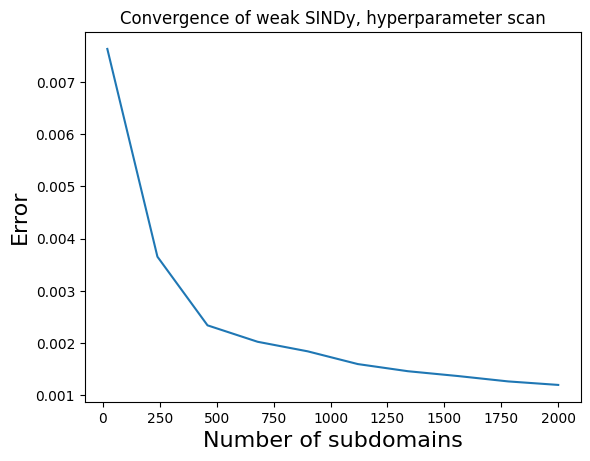

In [5]:
plt.title("Convergence of weak SINDy, hyperparameter scan", fontsize=12)
plt.plot(K_scan, errs)
plt.xlabel("Number of subdomains", fontsize=16)
plt.ylabel("Error", fontsize=16)
plt.show()

The default scikit-learn functionality for `model.predict` is to return x_dot of the same type as the training data. So for weak form, model.predict returns a prediction of the weak form of x_dot, rather than a prediction of x_dot.

We can get around this with a bit of a cheat... inputting the model coefficients from the weak form into the original (not weak) model, and use this to predict!
Beware, this requires: 
1. That the libraries and library ordering are identical in the two models!
2. For PDEs, the spatial grids must be identical. This means you need to reuse the library. If you initialize a new PDE library, a new set of subdomains is randomly chosen.
3. Note that the candidate libraries $\Theta$ are fundamentally different in the weak and non-weak models. In the former, all the columns are integrated in time (and for PDEs, also in space)! This means if you forecast the weak model coefficients with the non-weak model, you are using a $\Theta$ matrix that is very noisy! In other words, using the weak form fixed the issues with noise, but forecasting with the original model still has the noise in $\Theta$.
4. For all these reasons, we will use the error in the coefficients, rather than the error in the predictions, after this example.

Weak form model: 
(x0)' = -29.061 1 + -11.854 x0 + 10.497 x1 + 3.391 x2 + 0.538 x0x0 + 0.066 x1x1 + -0.104 x2x2 + -0.436 x0x1 + 0.043 x0x2
(x1)' = 13.320 1 + 27.944 x0 + -0.883 x1 + -1.108 x2 + -0.103 x0x0 + -0.120 x1x1 + 0.025 x2x2 + 0.222 x0x1 + -0.999 x0x2
(x2)' = -10.974 1 + -0.585 x1 + -1.328 x2 + 0.173 x0x0 + -0.040 x2x2 + 0.889 x0x1 + 0.022 x1x2
Regular model: 
(x0)' = 93.894 1 + 11.748 x0 + -8.476 x2 + -0.053 x0x0 + -0.027 x1x1 + 0.163 x2x2 + 0.063 x0x1 + -0.464 x0x2 + 0.116 x1x2
(x1)' = 15.183 1 + 11.700 x0 + 6.015 x1 + -2.636 x2 + 0.544 x0x0 + 0.349 x1x1 + 0.053 x2x2 + -0.861 x0x1 + -0.489 x0x2 + -0.198 x1x2
(x2)' = 11.490 1 + 4.665 x0 + -0.501 x1 + -3.732 x2 + -0.175 x0x0 + 0.021 x1x1 + 0.051 x2x2 + 0.882 x0x1 + -0.056 x0x2 + -0.097 x1x2


/net/nfs/ssd1/miniconda3/envs/pysindy-repo/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


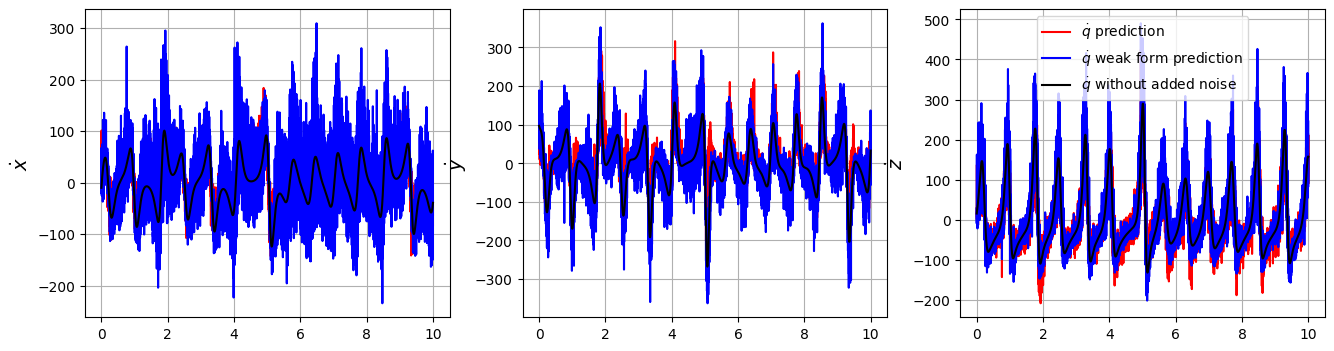

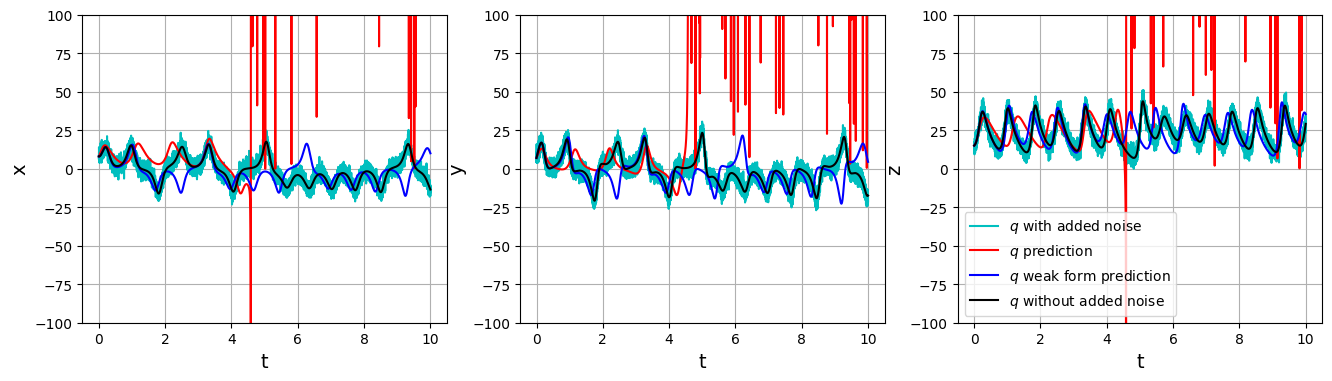

In [6]:
# Fit a weak form model
ode_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    spatiotemporal_grid=t_train,
    include_bias=True,
    is_uniform=True,
    K=5000,
)
opt = ps.SR3(
    threshold=100, thresholder="l0", max_iter=10000, normalize_columns=True, tol=1e-10
)
model = ps.SINDy(feature_library=ode_lib, optimizer=opt)
model.fit(u_train)
print("Weak form model: ")
model.print()

# Instantiate and fit a non-weak SINDy model
ode_lib = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=True,
)
optimizer = ps.SR3(
    threshold=100, thresholder="l0", max_iter=10000, normalize_columns=True, tol=1e-10
)
original_model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
original_model.fit(u_train, t=dt)
print("Regular model: ")
original_model.print()
err_not_weak = np.sqrt(
    (np.sum((u_dot - optimizer.Theta_ @ optimizer.coef_.T) ** 2) / np.sum(u_dot**2))
    / u_dot.shape[0]
)

u_pred = original_model.simulate(u0_test, t=t_train, integrator="odeint")
u_dot_pred = original_model.predict(u_test)

# Plot the ground truth, weak form, and non-weak derivative predictions
feature_names = ["x", "y", "z"]
optimizer.coef_ = opt.coef_
u_dot_weak = original_model.predict(u_test)
plt.figure(figsize=(16, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(t_train, u_dot_pred[:, i], "r", label=r"$\dot{q}$ prediction")
    plt.plot(t_train, u_dot_weak[:, i], "b", label=r"$\dot{q}$ weak form prediction")
    plt.plot(t_train, u_dot_clean[:, i], "k", label=r"$\dot{q}$ without added noise")
    plt.grid(True)
    plt.ylabel(r"$\dot{" + feature_names[i] + "}$", fontsize=14)
    if i == 2:
        plt.legend()

# Plot the ground truth, weak form, and non-weak trajectory predictions
u_weak = original_model.simulate(u0_test, t=t_train, integrator="odeint")
plt.figure(figsize=(16, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(t_train, u_test[:, i], "c", label=r"$q$ with added noise")
    plt.plot(t_train, u_pred[:, i], "r", label=r"$q$ prediction")
    plt.plot(t_train, u_weak[:, i], "b", label=r"$q$ weak form prediction")
    plt.plot(t_train, u_clean[:, i], "k", label=r"$q$ without added noise")
    plt.grid(True)
    plt.ylabel(feature_names[i], fontsize=14)
    plt.xlabel("t", fontsize=14)
    plt.ylim(-100, 100)
    if i == 2:
        plt.legend()

Weak form model: 
(x0)' = -29.381 1 + -11.807 x0 + 10.481 x1 + 3.420 x2 + 0.542 x0x0 + 0.069 x1x1 + -0.105 x2x2 + -0.443 x0x1 + 0.042 x0x2
(x1)' = 13.201 1 + 27.969 x0 + -0.885 x1 + -1.078 x2 + -0.100 x0x0 + -0.121 x1x1 + 0.024 x2x2 + 0.223 x0x1 + -1.000 x0x2
(x2)' = -10.487 1 + -0.601 x1 + -1.390 x2 + 0.161 x0x0 + -0.038 x2x2 + 0.896 x0x1 + 0.023 x1x2
Regular model: 
(x0)' = 93.894 1 + 11.748 x0 + -8.476 x2 + -0.053 x0x0 + -0.027 x1x1 + 0.163 x2x2 + 0.063 x0x1 + -0.464 x0x2 + 0.116 x1x2
(x1)' = 15.183 1 + 11.700 x0 + 6.015 x1 + -2.636 x2 + 0.544 x0x0 + 0.349 x1x1 + 0.053 x2x2 + -0.861 x0x1 + -0.489 x0x2 + -0.198 x1x2
(x2)' = 11.490 1 + 4.665 x0 + -0.501 x1 + -3.732 x2 + -0.175 x0x0 + 0.021 x1x1 + 0.051 x2x2 + 0.882 x0x1 + -0.056 x0x2 + -0.097 x1x2


/net/nfs/ssd1/miniconda3/envs/pysindy-repo/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


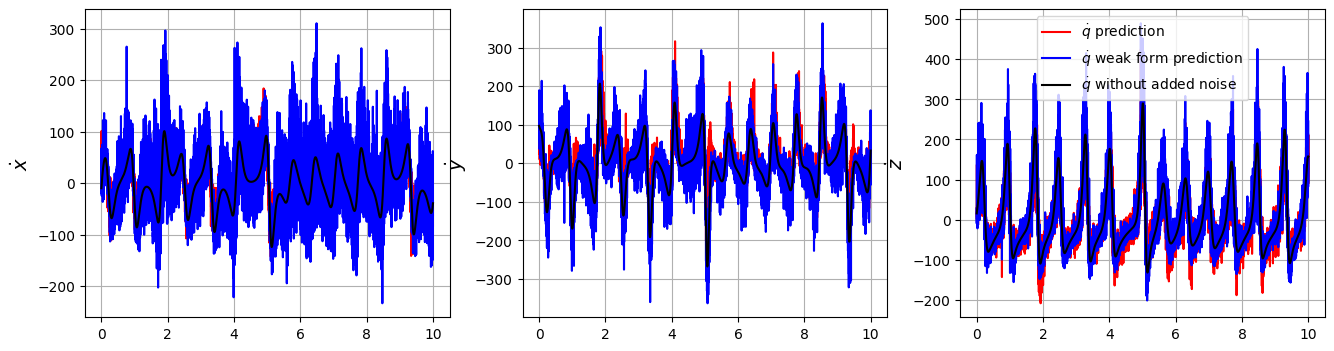

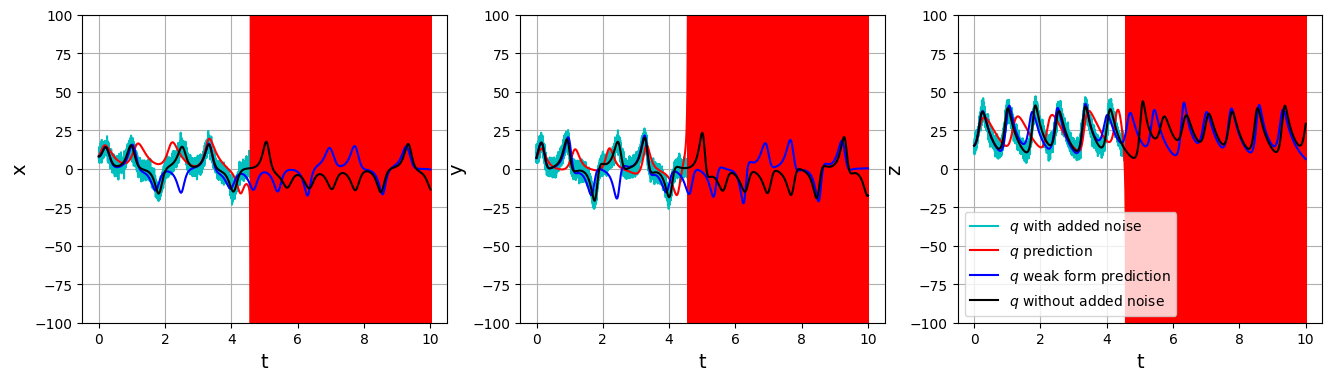

In [7]:
# Fit a weak form model
ode_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    spatiotemporal_grid=t_train,
    include_bias=True,
    is_uniform=True,
    K=5000,
)
opt = ps.SR3(
    threshold=100, thresholder="l0", max_iter=10000, normalize_columns=True, tol=1e-10
)
model = ps.SINDy(feature_library=ode_lib, optimizer=opt)
model.fit(u_train)
print("Weak form model: ")
model.print()

# Instantiate and fit a non-weak SINDy model
ode_lib = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=True,
)
optimizer = ps.SR3(
    threshold=100, thresholder="l0", max_iter=10000, normalize_columns=True, tol=1e-10
)
original_model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
original_model.fit(u_train, t=dt)
print("Regular model: ")
original_model.print()
err_not_weak = np.sqrt(
    (np.sum((u_dot - optimizer.Theta_ @ optimizer.coef_.T) ** 2) / np.sum(u_dot**2))
    / u_dot.shape[0]
)

u_pred = original_model.simulate(u0_test, t=t_train, integrator="odeint")
u_dot_pred = original_model.predict(u_test)

# Plot the ground truth, weak form, and non-weak derivative predictions
feature_names = ["x", "y", "z"]
optimizer.coef_ = opt.coef_
u_dot_weak = original_model.predict(u_test)
plt.figure(figsize=(16, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(t_train, u_dot_pred[:, i], "r", label=r"$\dot{q}$ prediction")
    plt.plot(t_train, u_dot_weak[:, i], "b", label=r"$\dot{q}$ weak form prediction")
    plt.plot(t_train, u_dot_clean[:, i], "k", label=r"$\dot{q}$ without added noise")
    plt.grid(True)
    plt.ylabel(r"$\dot{" + feature_names[i] + "}$", fontsize=14)
    if i == 2:
        plt.legend()

# Plot the ground truth, weak form, and non-weak trajectory predictions
u_weak = original_model.simulate(u0_test, t=t_train, integrator="odeint")
plt.figure(figsize=(16, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(t_train, u_test[:, i], "c", label=r"$q$ with added noise")
    plt.plot(t_train, u_pred[:, i], "r", label=r"$q$ prediction")
    plt.plot(t_train, u_weak[:, i], "b", label=r"$q$ weak form prediction")
    plt.plot(t_train, u_clean[:, i], "k", label=r"$q$ without added noise")
    plt.grid(True)
    plt.ylabel(feature_names[i], fontsize=14)
    plt.xlabel("t", fontsize=14)
    plt.ylim(-100, 100)
    if i == 2:
        plt.legend()

# Test weak form PDE functionality on Burgers' equation with 20% noise
Note that the weak formulation can be applied to PDEs too. 
Burgers' equation is
$u_t = -uu_x + 0.1 u_{xx}$. We will repeat all the same steps. Although weak-formulation helps with noisy data, we also show that using smoothed finite-differences (or other more advanced differentiation schemes) can also improve robustness to noise.

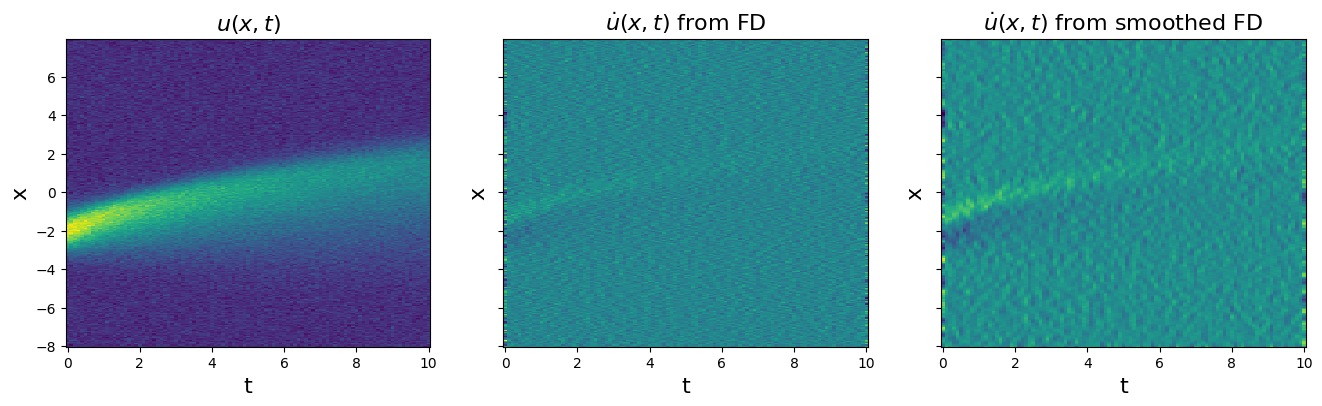

In [2]:
data = loadmat("data/burgers.mat")
time = np.ravel(data["t"])
x = np.ravel(data["x"])
u = np.real(data["usol"])
dt = time[1] - time[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
# add 20% noise (note the impact on derivatives depends on step size...)
u = u + np.random.normal(0, rmse / 5.0, u.shape)

# Plot u and u_dot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(time, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 2)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from FD", fontsize=16)

u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 3)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from smoothed FD", fontsize=16)
plt.show()
# See how much SmoothedFiniteDifference improves the derivatives!

u = np.reshape(u, (len(x), len(time), 1))

In [3]:
%%time
# Define weak form PDE library
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

# Need to define the 2D spatiotemporal grid before calling the library
X, T = np.meshgrid(x, time)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
)


# Fit a weak form model
optimizer = ps.SR3(
    threshold=0.1, thresholder="l0", tol=1e-8, normalize_columns=True, max_iter=1000
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u)
model.print()

(x0)' = 0.086 x0_11 + -1.028 x0x0_1
CPU times: user 817 ms, sys: 26.2 ms, total: 843 ms
Wall time: 834 ms


In [4]:
%%time
# Show that a non-weak form model screws this up badly
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    include_bias=False,
    is_uniform=True,
)

# Fit and predict with the non-weak model
opt = ps.SR3(
    threshold=0.05, thresholder="l0", tol=1e-10, normalize_columns=True, max_iter=1000
)
model_for_prediction = ps.SINDy(feature_library=pde_lib, optimizer=opt)
model_for_prediction.fit(u)

# Prints a very wrong model
model_for_prediction.print()

(x0)' = 0.011 x0 + -0.031 x0x0 + -0.001 x0_1 + -0.012 x0x0_1 + -0.028 x0x0x0_1
CPU times: user 16 ms, sys: 12.2 ms, total: 28.2 ms
Wall time: 25.8 ms


## Sensetivity to `threshold`

In [5]:
%%time

for threshold in [0.03, 0.05, 0.07, 0.09, 0.1, 0.11, 0.12, 0.15, 0.2, 0.3]:
    # Define weak form PDE library
    library_functions = [lambda x: x, lambda x: x * x]
    library_function_names = [lambda x: x, lambda x: x + x]

    # Need to define the 2D spatiotemporal grid before calling the library
    X, T = np.meshgrid(x, time)
    XT = np.asarray([X, T]).T
    pde_lib = ps.WeakPDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        derivative_order=2,
        spatiotemporal_grid=XT,
        is_uniform=True,
        K=1000,
    )


    # Fit a weak form model
    optimizer = ps.SR3(
        threshold=threshold, thresholder="l0", tol=1e-8, normalize_columns=True, max_iter=1000
    )
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
    model.fit(u)
    print(f"Threshold: {threshold} :\t ", end="")
    model.print()

Threshold: 0.03 :	 (x0)' = 0.036 x0 + -0.114 x0x0 + -0.092 x0_1 + 0.069 x0_11 + -0.599 x0x0_1 + -0.280 x0x0x0_1
Threshold: 0.05 :	 (x0)' = 0.058 x0 + -0.153 x0x0 + -0.069 x0_1 + 0.071 x0_11 + -0.819 x0x0_1
Threshold: 0.07 :	 (x0)' = 0.063 x0 + -0.150 x0x0 + -0.091 x0_1 + 0.060 x0_11 + -0.755 x0x0_1
Threshold: 0.09 :	 (x0)' = 0.087 x0_11 + -0.967 x0x0_1
Threshold: 0.1 :	 (x0)' = 0.087 x0_11 + -1.019 x0x0_1
Threshold: 0.11 :	 (x0)' = -0.991 x0x0_1
Threshold: 0.12 :	 (x0)' = -0.946 x0x0_1
Threshold: 0.15 :	 (x0)' = -0.985 x0x0_1
Threshold: 0.2 :	 (x0)' = -0.947 x0x0_1
Threshold: 0.3 :	 (x0)' = 0.000
CPU times: user 8.63 s, sys: 23.5 ms, total: 8.65 s
Wall time: 8.64 s


The model is extremely sensitive towards threshold

## Trying 50 percent noise

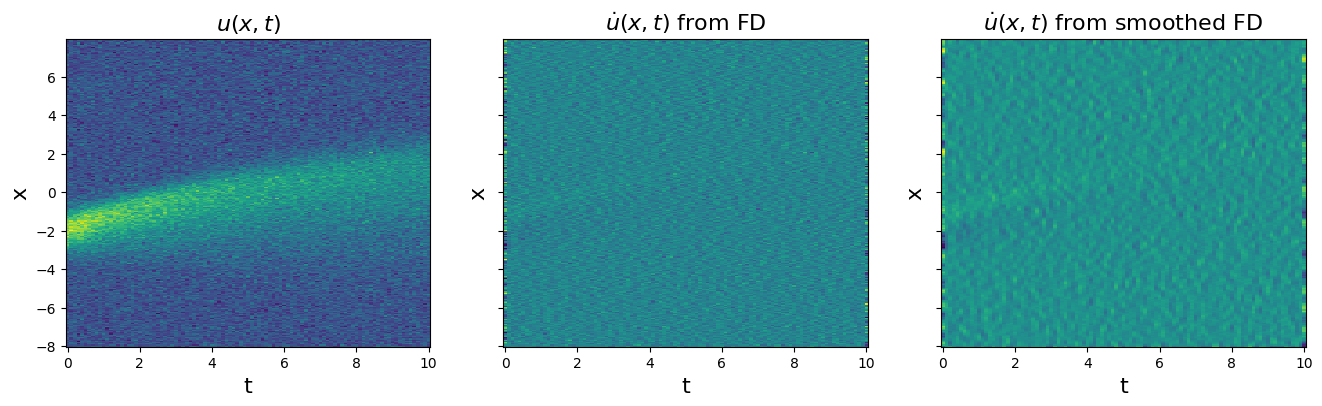

In [18]:
data = loadmat("data/burgers.mat")
time = np.ravel(data["t"])
x = np.ravel(data["x"])
u = np.real(data["usol"])
dt = time[1] - time[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
# add 50% noise (note the impact on derivatives depends on step size...)
u = u + np.random.normal(0, rmse / 2.0, u.shape)

# Plot u and u_dot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(time, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 2)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from FD", fontsize=16)

u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 3)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from smoothed FD", fontsize=16)
plt.show()
# See how much SmoothedFiniteDifference improves the derivatives!

u = np.reshape(u, (len(x), len(time), 1))

In [19]:
%%time

for threshold in [0.03, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.15, 0.2, 0.3]:
    # Define weak form PDE library
    library_functions = [lambda x: x, lambda x: x * x]
    library_function_names = [lambda x: x, lambda x: x + x]

    # Need to define the 2D spatiotemporal grid before calling the library
    X, T = np.meshgrid(x, time)
    XT = np.asarray([X, T]).T
    pde_lib = ps.WeakPDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        derivative_order=2,
        spatiotemporal_grid=XT,
        is_uniform=True,
        K=1000,
    )


    # Fit a weak form model
    optimizer = ps.SR3(
        threshold=threshold, thresholder="l0", tol=1e-8, normalize_columns=True, max_iter=1000
    )
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
    model.fit(u)
    print(f"Threshold: {threshold} :\t ", end="")
    model.print()

Threshold: 0.03 :	 (x0)' = 0.184 x0 + -0.353 x0x0 + -0.183 x0_1 + 0.024 x0_11 + -0.190 x0x0_1 + -0.622 x0x0x0_1 + -0.004 x0x0_11 + 0.023 x0x0x0_11
Threshold: 0.05 :	 (x0)' = 0.120 x0 + -0.203 x0x0 + -0.133 x0_1 + 0.039 x0_11 + -0.358 x0x0_1 + -0.541 x0x0x0_1 + 0.014 x0x0x0_11
Threshold: 0.06 :	 (x0)' = 0.131 x0 + -0.211 x0x0 + -0.215 x0_1 + 0.145 x0x0_1 + -1.101 x0x0x0_1 + 0.028 x0x0x0_11
Threshold: 0.07 :	 (x0)' = 0.099 x0 + -0.249 x0x0 + -0.145 x0_1 + -0.317 x0x0_1 + -0.551 x0x0x0_1
Threshold: 0.08 :	 (x0)' = 0.097 x0 + -0.287 x0x0 + -0.117 x0_1 + -0.350 x0x0_1 + -0.502 x0x0x0_1
Threshold: 0.09 :	 (x0)' = 0.290 x0 + -0.373 x0x0 + -0.173 x0_1 + -0.524 x0x0_1 + 0.044 x0x0x0_11
Threshold: 0.1 :	 (x0)' = 0.163 x0 + -0.289 x0x0 + -0.201 x0_1 + -0.441 x0x0_1 + 0.023 x0x0x0_11
Threshold: 0.11 :	 (x0)' = 0.250 x0 + -0.350 x0x0 + -0.147 x0_1 + -0.577 x0x0_1 + 0.042 x0x0x0_11
Threshold: 0.12 :	 (x0)' = 0.110 x0 + -0.334 x0x0 + -0.180 x0_1 + -0.515 x0x0_1
Threshold: 0.15 :	 (x0)' = 0.175 x0 + -

It becomes even more sensitive to threshold and erratic: other times the correct equation was not reconstructed for the same parameters

The takeaway here is that the weak formulation drastically improved our system identification on the Burgers' equation with added noise. The weak formulation can handle even more than 20% noise here, although then a fairly large value for K is required to obtain a decent system identification. This is required for some of the examples below, and the downside is that this slows down the code considerably. 

## Cahn - Hilliard equation

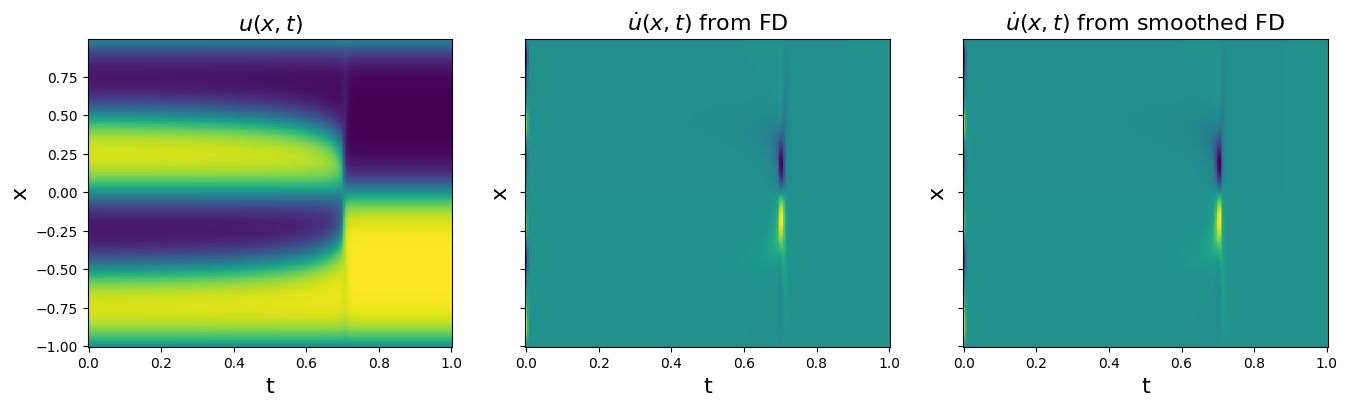

In [19]:
data = loadmat("../../PDE-READ/Matlab/Data/Cahn_Hilliard_Sine.mat")
time = np.ravel(data["t"])
x = np.ravel(data["x"])
u = np.real(data["usol"])
dt = time[1] - time[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
# add 50% noise (note the impact on derivatives depends on step size...)
# u = u + np.random.normal(0, rmse / 2.0, u.shape)

# Plot u and u_dot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(time, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 2)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from FD", fontsize=16)

u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 3)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from smoothed FD", fontsize=16)
plt.show()
# See how much SmoothedFiniteDifference improves the derivatives!

u = np.reshape(u, (len(x), len(time), 1))

In [22]:
%%time

for threshold in [0.0001, 0.001, 0.01, 0.02, 0.03, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.15, 0.2, 0.3, 0.4, 0.5, 0.8]:
    # Define weak form PDE library
    library_functions = [lambda x: x, lambda x: x * x]
    library_function_names = [lambda x: x, lambda x: x + x]

    # Need to define the 2D spatiotemporal grid before calling the library
    X, T = np.meshgrid(x, time)
    XT = np.asarray([X, T]).T
    pde_lib = ps.WeakPDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        derivative_order=4,
        spatiotemporal_grid=XT,
        is_uniform=True,
        K=2000,
    )


    # Fit a weak form model
    optimizer = ps.SR3(
        threshold=threshold, thresholder="l0", tol=1e-8, normalize_columns=True, max_iter=1000
    )
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
    model.fit(u)
    print(f"Threshold: {threshold} :\t ", end="")
    model.print()

Threshold: 0.0001 :	 (x0)' = 0.456 x0 + 0.063 x0x0 + -2.797 x0_1 + 0.814 x0_11 + -0.028 x0_111 + 0.002 x0_1111 + -0.031 x0x0_1 + 8.451 x0x0x0_1 + 0.001 x0x0_11 + -1.353 x0x0x0_11 + -0.002 x0x0_111 + -0.001 x0x0x0_111
Threshold: 0.001 :	 (x0)' = 0.505 x0 + -0.189 x0x0 + 0.409 x0_1 + 1.105 x0_11 + 0.004 x0_111 + 0.003 x0_1111 + -0.014 x0x0_1 + -1.284 x0x0x0_1 + -0.006 x0x0_11 + -1.834 x0x0x0_11 + -0.003 x0x0_111 + 0.002 x0x0x0_111
Threshold: 0.01 :	 (x0)' = 0.108 x0 + -4.686 x0_1 + 0.917 x0_11 + -0.047 x0_111 + 0.002 x0_1111 + 13.976 x0x0x0_1 + -1.544 x0x0x0_11 + -0.004 x0x0_111 + 0.003 x0x0x0_111
Threshold: 0.02 :	 (x0)' = 3.865 x0_1 + 1.028 x0_11 + 0.039 x0_111 + 0.003 x0_1111 + -11.556 x0x0x0_1 + -1.733 x0x0x0_11 + -0.004 x0x0_111
Threshold: 0.03 :	 (x0)' = -4.719 x0_1 + 1.043 x0_11 + -0.047 x0_111 + 0.003 x0_1111 + 14.124 x0x0x0_1 + -1.762 x0x0x0_11 + -0.004 x0x0_111
Threshold: 0.05 :	 (x0)' = 3.209 x0_1 + 0.971 x0_11 + 0.032 x0_111 + 0.003 x0_1111 + -9.641 x0x0x0_1 + -1.641 x0x0x0_1

## Kuramoto - Sivashinsky Cosine

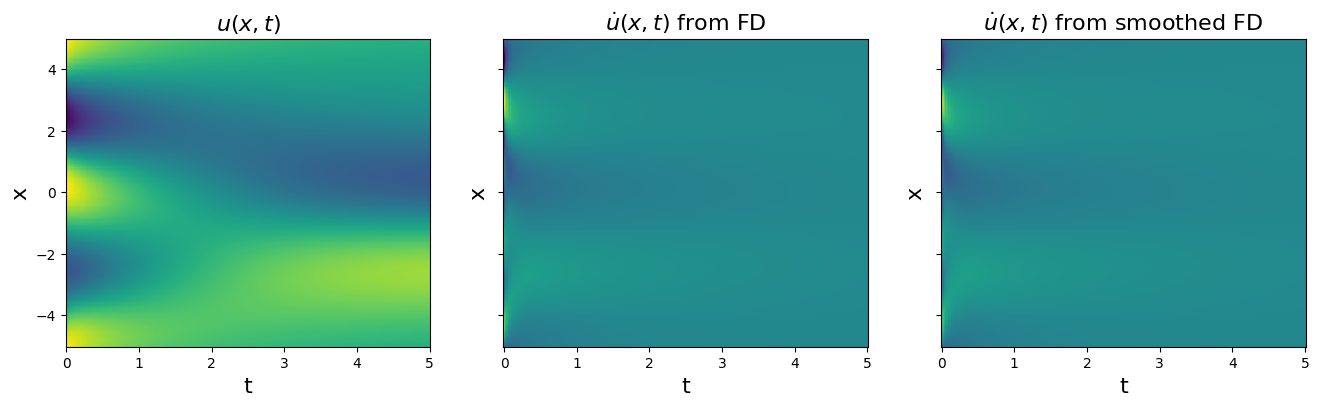

In [9]:
data = loadmat("../../PDE-READ/Matlab/Data/KS_Cos.mat")
time = np.ravel(data["t"])
x = np.ravel(data["x"])
u = np.real(data["usol"])
dt = time[1] - time[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
# add 50% noise (note the impact on derivatives depends on step size...)
# u = u + np.random.normal(0, rmse / 2.0, u.shape)

# Plot u and u_dot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(time, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 2)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from FD", fontsize=16)

u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 3)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from smoothed FD", fontsize=16)
plt.show()
# See how much SmoothedFiniteDifference improves the derivatives!

u = np.reshape(u, (len(x), len(time), 1))

In [11]:
%%time
# Define weak form PDE library
library_functions = [lambda x: x, lambda x: x * x, lambda x: x * x * x]
library_function_names = [lambda x: x, lambda x: x + x, lambda x: x + x + x]

# Need to define the 2D spatiotemporal grid before calling the library
X, T = np.meshgrid(x, time)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
)


# Fit a weak form model
optimizer = ps.SR3(
    threshold=0.1, thresholder="l0", tol=1e-8, normalize_columns=True, max_iter=1000
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u)
model.print()

(x0)' = -1.002 x0_11 + -1.000 x0_1111 + -1.000 x0x0_1
CPU times: user 1.47 s, sys: 3.97 ms, total: 1.48 s
Wall time: 1.48 s


### adding noise

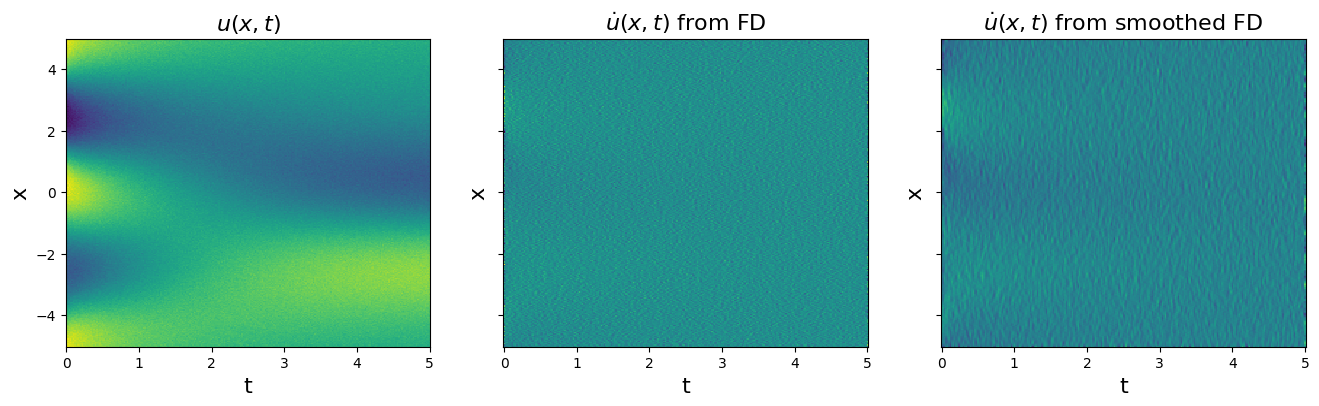

In [17]:
data = loadmat("../../PDE-READ/Matlab/Data/KS_Cos.mat")
time = np.ravel(data["t"])
x = np.ravel(data["x"])
u = np.real(data["usol"])
dt = time[1] - time[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
# add 10% noise (note the impact on derivatives depends on step size...)
u = u + 0.1*np.random.normal(0, rmse, u.shape)

# Plot u and u_dot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(time, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 2)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from FD", fontsize=16)

u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 3)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from smoothed FD", fontsize=16)
plt.show()
# See how much SmoothedFiniteDifference improves the derivatives!

u = np.reshape(u, (len(x), len(time), 1))

In [18]:
%%time

for threshold in [0.0001, 0.001, 0.01, 0.02, 0.03, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.15, 0.2, 0.3, 0.4, 0.5, 0.8]:
    # Define weak form PDE library
    library_functions = [lambda x: x, lambda x: x * x, lambda x: x * x * x]
    library_function_names = [lambda x: x, lambda x: x + x, lambda x: x + x + x]

    # Need to define the 2D spatiotemporal grid before calling the library
    X, T = np.meshgrid(x, time)
    XT = np.asarray([X, T]).T
    pde_lib = ps.WeakPDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        derivative_order=2,
        spatiotemporal_grid=XT,
        is_uniform=True,
        K=2000,
    )


    # Fit a weak form model
    optimizer = ps.SR3(
        threshold=threshold, thresholder="l0", tol=1e-8, normalize_columns=True, max_iter=1000
    )
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
    model.fit(u)
    print(f"Threshold: {threshold} :\t ", end="")
    model.print()

Threshold: 0.0001 :	 (x0)' = 0.445 x0 + -0.157 x0x0 + 0.020 x0x0x0 + 0.061 x0_1 + 0.759 x0_11 + -0.518 x0x0_1 + 0.019 x0x0x0_1 + 0.088 x0x0x0x0_1 + -0.006 x0x0_11 + 0.003 x0x0x0_11 + -0.011 x0x0x0x0_11
Threshold: 0.001 :	 (x0)' = 0.580 x0 + -0.058 x0x0 + 0.033 x0x0x0 + 0.064 x0_1 + 0.779 x0_11 + -0.489 x0x0_1 + 0.009 x0x0x0_1 + 0.066 x0x0x0x0_1 + -0.002 x0x0_11 + 0.016 x0x0x0_11 + -0.005 x0x0x0x0_11
Threshold: 0.01 :	 (x0)' = 0.571 x0 + -0.170 x0x0 + 0.031 x0x0x0 + 0.045 x0_1 + 0.745 x0_11 + -0.498 x0x0_1 + 0.018 x0x0x0_1 + 0.081 x0x0x0x0_1 + -0.008 x0x0_11 + 0.018 x0x0x0_11 + -0.011 x0x0x0x0_11
Threshold: 0.02 :	 (x0)' = 0.514 x0 + -0.104 x0x0 + 0.044 x0x0x0 + 0.035 x0_1 + 0.804 x0_11 + -0.494 x0x0_1 + 0.024 x0x0x0_1 + 0.071 x0x0x0x0_1 + -0.009 x0x0_11 + 0.012 x0x0x0_11 + -0.006 x0x0x0x0_11
Threshold: 0.03 :	 (x0)' = 0.581 x0 + -0.128 x0x0 + 0.057 x0x0x0 + 0.060 x0_1 + 0.758 x0_11 + -0.490 x0x0_1 + 0.064 x0x0x0x0_1 + -0.006 x0x0_11 + 0.026 x0x0x0_11 + -0.009 x0x0x0x0_11
Threshold: 0.0

## Trying Allen Cahn equation

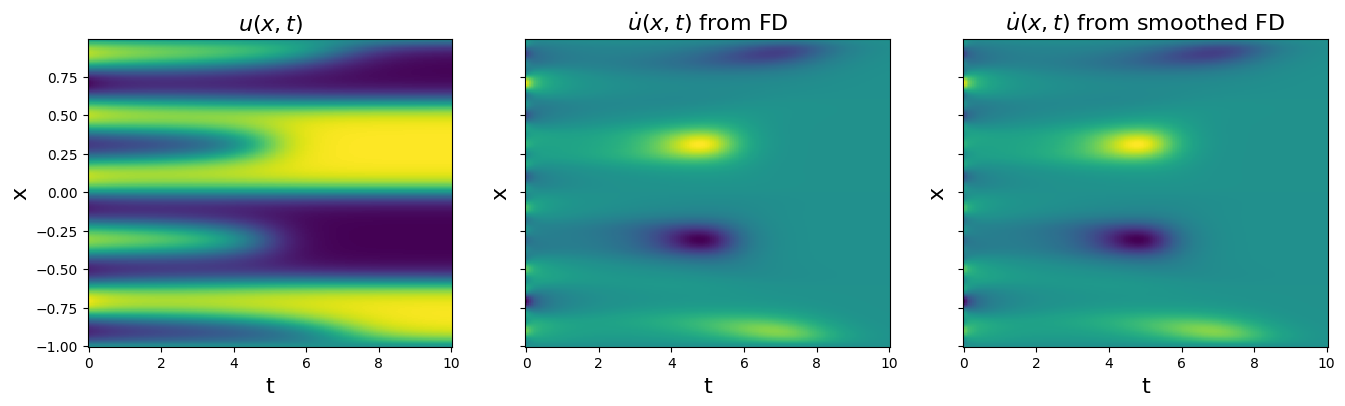

In [22]:
data = loadmat("../../PDE-READ/Matlab/Data/Allen_Cahn.mat")
time = np.ravel(data["t"])
x = np.ravel(data["x"])
u = np.real(data["usol"])
dt = time[1] - time[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
# add 50% noise (note the impact on derivatives depends on step size...)
# u = u + np.random.normal(0, rmse / 2.0, u.shape)

# Plot u and u_dot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(time, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 2)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from FD", fontsize=16)

u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 3)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from smoothed FD", fontsize=16)
plt.show()
# See how much SmoothedFiniteDifference improves the derivatives!

u = np.reshape(u, (len(x), len(time), 1))

In [23]:
%%time
# Define weak form PDE library
library_functions = [lambda x: x, lambda x: x * x, lambda x: x * x * x]
library_function_names = [lambda x: x, lambda x: x + x, lambda x: x + x + x]

# Need to define the 2D spatiotemporal grid before calling the library
X, T = np.meshgrid(x, time)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
)


# Fit a weak form model
optimizer = ps.SR3(
    threshold=0.1, thresholder="l0", tol=1e-8, normalize_columns=True, max_iter=1000
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u)
model.print()

(x0)' = 1.000 x0 + -1.000 x0x0x0 + 0.003 x0_11
CPU times: user 864 ms, sys: 8.04 ms, total: 872 ms
Wall time: 870 ms


### adding noise

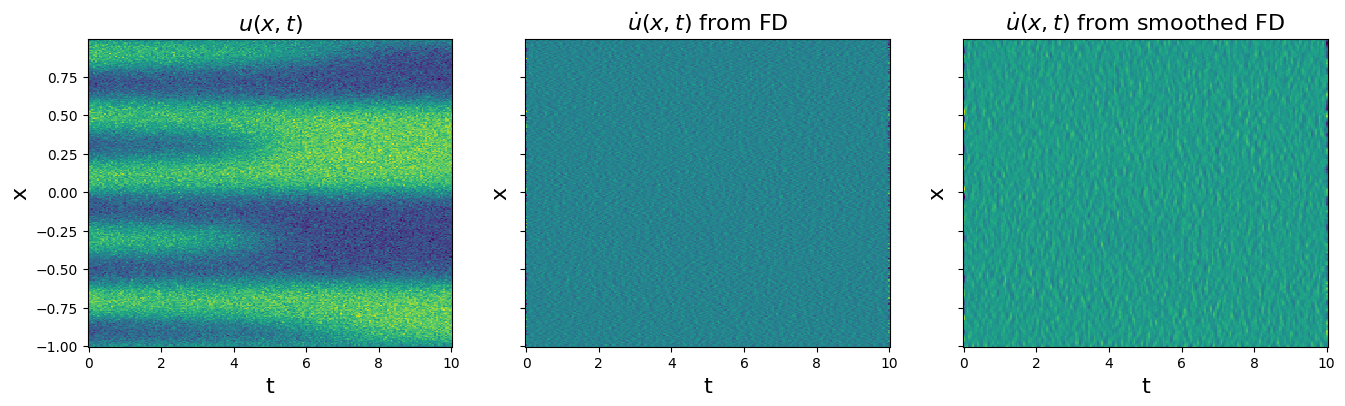

In [48]:
data = loadmat("../../PDE-READ/Matlab/Data/Allen_Cahn.mat")
time = np.ravel(data["t"])
x = np.ravel(data["x"])
u = np.real(data["usol"])
dt = time[1] - time[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
# add 40% noise (note the impact on derivatives depends on step size...)
u = u + 0.4*np.random.normal(0, rmse, u.shape)

# Plot u and u_dot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(time, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 2)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from FD", fontsize=16)

u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 3)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from smoothed FD", fontsize=16)
plt.show()
# See how much SmoothedFiniteDifference improves the derivatives!

u = np.reshape(u, (len(x), len(time), 1))

In [49]:
%%time

for threshold in [0.0001, 0.001, 0.01, 0.02, 0.03, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.15, 0.2, 0.3, 0.4]:
    # Define weak form PDE library
    library_functions = [lambda x: x, lambda x: x * x, lambda x: x * x * x]
    library_function_names = [lambda x: x, lambda x: x + x, lambda x: x + x + x]

    # Need to define the 2D spatiotemporal grid before calling the library
    X, T = np.meshgrid(x, time)
    XT = np.asarray([X, T]).T
    pde_lib = ps.WeakPDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        derivative_order=2,
        spatiotemporal_grid=XT,
        is_uniform=True,
        K=2000,
    )


    # Fit a weak form model
    optimizer = ps.SR3(
        threshold=threshold, thresholder="l0", tol=1e-8, normalize_columns=True, max_iter=1000
    )
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
    model.fit(u)
    print(f"Threshold: {threshold} :\t ", end="")
    model.print()

Threshold: 0.0001 :	 (x0)' = 0.783 x0 + 0.071 x0x0 + -0.743 x0x0x0 + 0.001 x0_1 + 0.002 x0_11 + -0.001 x0x0_1 + -0.002 x0x0x0_1 + 0.001 x0x0x0x0_1
Threshold: 0.001 :	 (x0)' = 0.846 x0 + 0.086 x0x0 + -0.802 x0x0x0 + 0.002 x0_11 + -0.006 x0x0_1 + -0.002 x0x0x0_1 + 0.011 x0x0x0x0_1
Threshold: 0.01 :	 (x0)' = 0.762 x0 + 0.055 x0x0 + -0.755 x0x0x0 + 0.002 x0_1 + 0.002 x0_11 + -0.006 x0x0x0_1 + 0.008 x0x0x0x0_1
Threshold: 0.02 :	 (x0)' = 0.806 x0 + 0.061 x0x0 + -0.752 x0x0x0 + 0.002 x0_11
Threshold: 0.03 :	 (x0)' = 0.737 x0 + 0.048 x0x0 + -0.729 x0x0x0 + 0.002 x0_11
Threshold: 0.05 :	 (x0)' = 0.798 x0 + 0.083 x0x0 + -0.739 x0x0x0 + 0.002 x0_11
Threshold: 0.06 :	 (x0)' = 0.759 x0 + 0.103 x0x0 + -0.740 x0x0x0 + 0.002 x0_11
Threshold: 0.07 :	 (x0)' = 0.743 x0 + 0.094 x0x0 + -0.761 x0x0x0 + 0.002 x0_11
Threshold: 0.08 :	 (x0)' = 0.709 x0 + -0.711 x0x0x0 + 0.002 x0_11
Threshold: 0.09 :	 (x0)' = 0.777 x0 + -0.766 x0x0x0 + 0.002 x0_11
Threshold: 0.1 :	 (x0)' = 0.885 x0 + -0.738 x0x0x0 + 0.002 x0_11

## Trying Chafee - Infante

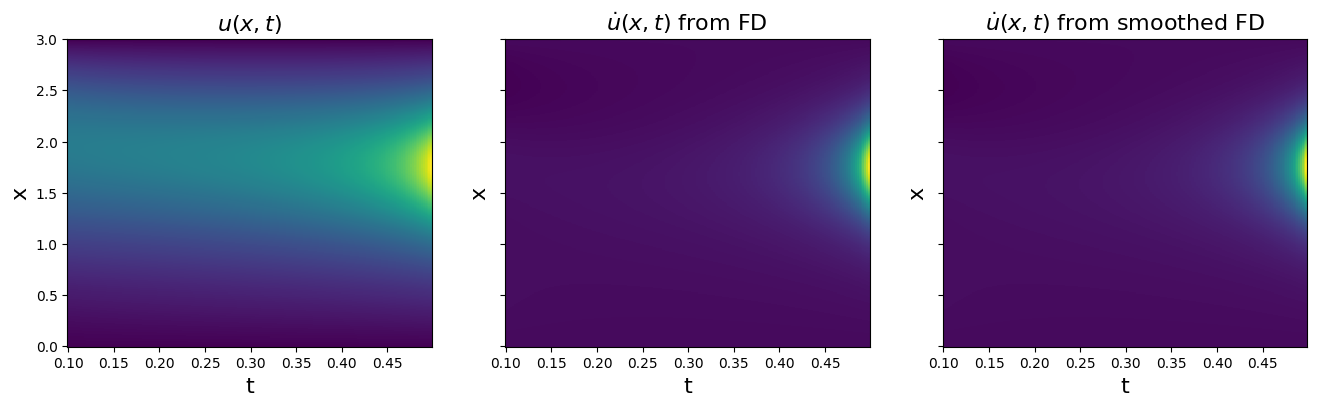

In [58]:
u = np.load("../../SGA-PDE/data/chafee_infante_CI.npy", allow_pickle=True)
x = np.load("../../SGA-PDE/data/chafee_infante_x.npy", allow_pickle=True)
time = np.load("../../SGA-PDE/data/chafee_infante_t.npy", allow_pickle=True)
dt = time[1] - time[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
# add 50% noise (note the impact on derivatives depends on step size...)
# u = u + np.random.normal(0, rmse / 2.0, u.shape)

# Plot u and u_dot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(time, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 2)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from FD", fontsize=16)

u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 3)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from smoothed FD", fontsize=16)
plt.show()
# See how much SmoothedFiniteDifference improves the derivatives!

u = np.reshape(u, (len(x), len(time), 1))

In [60]:
%%time

for threshold in [0.0001, 0.001, 0.01, 0.02, 0.03, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.15, 0.2, 0.3, 0.4]:
    # Define weak form PDE library
    library_functions = [lambda x: x, lambda x: x * x, lambda x: x * x * x]
    library_function_names = [lambda x: x, lambda x: x + x, lambda x: x + x + x]

    # Need to define the 2D spatiotemporal grid before calling the library
    X, T = np.meshgrid(x, time)
    XT = np.asarray([X, T]).T
    pde_lib = ps.WeakPDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        derivative_order=2,
        spatiotemporal_grid=XT,
        is_uniform=True,
        K=2000,
    )


    # Fit a weak form model
    optimizer = ps.SR3(
        threshold=threshold, thresholder="l0", tol=1e-8, normalize_columns=True, max_iter=1000
    )
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
    model.fit(u)
    print(f"Threshold: {threshold} :\t ", end="")
    model.print()

Threshold: 0.0001 :	 (x0)' = -1.001 x0 + 0.001 x0x0 + 1.000 x0x0x0 + 1.000 x0_11
Threshold: 0.001 :	 (x0)' = -1.000 x0 + 1.000 x0x0x0 + 1.000 x0_11
Threshold: 0.01 :	 (x0)' = -1.000 x0 + 1.000 x0x0x0 + 1.000 x0_11
Threshold: 0.02 :	 (x0)' = -1.000 x0 + 1.000 x0x0x0 + 1.000 x0_11
Threshold: 0.03 :	 (x0)' = -1.000 x0 + 1.000 x0x0x0 + 1.000 x0_11
Threshold: 0.05 :	 (x0)' = -1.000 x0 + 1.000 x0x0x0 + 1.000 x0_11
Threshold: 0.06 :	 (x0)' = -1.000 x0 + 1.000 x0x0x0 + 1.000 x0_11
Threshold: 0.07 :	 (x0)' = -1.000 x0 + 1.000 x0x0x0 + 1.000 x0_11
Threshold: 0.08 :	 (x0)' = -1.000 x0 + 1.000 x0x0x0 + 1.000 x0_11
Threshold: 0.09 :	 (x0)' = -1.000 x0 + 1.000 x0x0x0 + 1.000 x0_11
Threshold: 0.1 :	 (x0)' = -1.000 x0 + 1.000 x0x0x0 + 1.000 x0_11
Threshold: 0.11 :	 (x0)' = -1.000 x0 + 1.000 x0x0x0 + 1.000 x0_11
Threshold: 0.12 :	 (x0)' = 0.821 x0x0x0 + 0.944 x0_11
Threshold: 0.15 :	 (x0)' = 0.825 x0x0x0 + 0.955 x0_11
Threshold: 0.2 :	 (x0)' = 0.824 x0x0x0 + 0.952 x0_11
Threshold: 0.3 :	 (x0)' = 0.611 

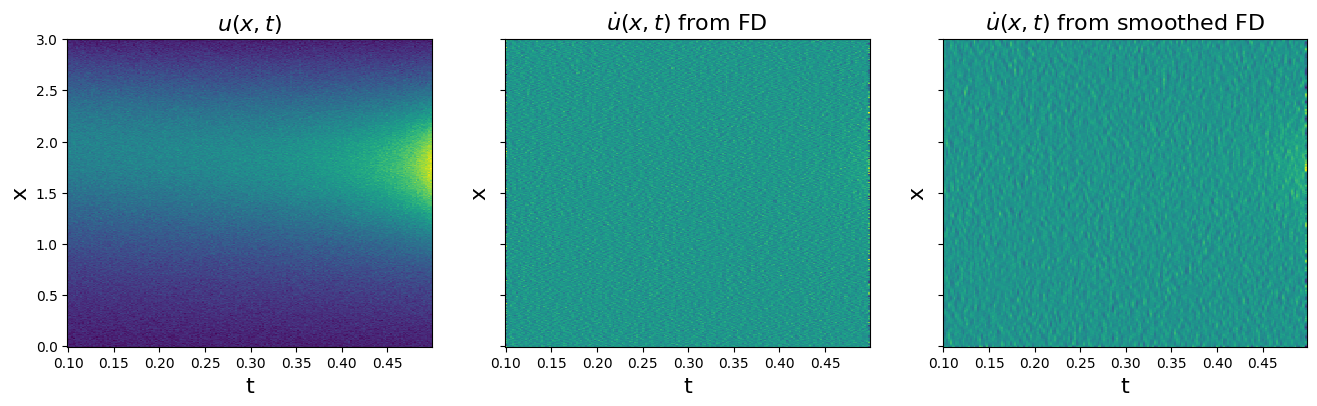

In [6]:
u = np.load("../../SGA-PDE/data/chafee_infante_CI.npy", allow_pickle=True)
x = np.load("../../SGA-PDE/data/chafee_infante_x.npy", allow_pickle=True)
time = np.load("../../SGA-PDE/data/chafee_infante_t.npy", allow_pickle=True)
dt = time[1] - time[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
# add 10% noise (note the impact on derivatives depends on step size...)
u = u + np.random.normal(0, rmse / 10.0, u.shape)

# Plot u and u_dot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(time, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 2)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from FD", fontsize=16)

u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 3)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from smoothed FD", fontsize=16)
plt.show()
# See how much SmoothedFiniteDifference improves the derivatives!

u = np.reshape(u, (len(x), len(time), 1))

In [7]:
%%time

for threshold in [0.0001, 0.001, 0.01, 0.02, 0.03, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.15, 0.2, 0.3, 0.4]:
    # Define weak form PDE library
    library_functions = [lambda x: x, lambda x: x * x, lambda x: x * x * x]
    library_function_names = [lambda x: x, lambda x: x + x, lambda x: x + x + x]

    # Need to define the 2D spatiotemporal grid before calling the library
    X, T = np.meshgrid(x, time)
    XT = np.asarray([X, T]).T
    pde_lib = ps.WeakPDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        derivative_order=2,
        spatiotemporal_grid=XT,
        is_uniform=True,
        K=2000,
    )


    # Fit a weak form model
    optimizer = ps.SR3(
        threshold=threshold, thresholder="l0", tol=1e-8, normalize_columns=True, max_iter=1000
    )
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
    model.fit(u)
    print(f"Threshold: {threshold} :\t ", end="")
    model.print()

Threshold: 0.0001 :	 (x0)' = 3.200 x0 + -3.932 x0x0 + 1.624 x0x0x0 + -0.305 x0_1 + 0.080 x0_11 + 1.104 x0x0_1 + -0.594 x0x0x0_1 + 0.089 x0x0x0x0_1 + 0.004 x0x0_11 + -0.004 x0x0x0_11 + 0.002 x0x0x0x0_11
Threshold: 0.001 :	 (x0)' = 2.591 x0 + -3.551 x0x0 + 1.631 x0x0x0 + 0.334 x0_1 + 0.063 x0_11 + -0.342 x0x0_1 + 0.350 x0x0x0_1 + -0.081 x0x0x0x0_1 + 0.007 x0x0_11 + -0.009 x0x0x0_11 + 0.003 x0x0x0x0_11
Threshold: 0.01 :	 (x0)' = 2.356 x0 + -3.357 x0x0 + 1.567 x0x0x0 + 0.086 x0_11 + 0.196 x0x0_1 + 0.078 x0x0x0_1 + -0.047 x0x0x0x0_1 + 0.005 x0x0_11 + -0.008 x0x0x0_11 + 0.003 x0x0x0x0_11
Threshold: 0.02 :	 (x0)' = 1.807 x0 + -3.110 x0x0 + 1.630 x0x0x0 + 0.303 x0_1 + 0.075 x0_11 + -0.349 x0x0_1 + 0.430 x0x0x0_1 + -0.124 x0x0x0x0_1 + 0.006 x0x0_11 + -0.011 x0x0x0_11 + 0.004 x0x0x0x0_11
Threshold: 0.03 :	 (x0)' = 2.185 x0 + -3.703 x0x0 + 1.692 x0x0x0 + 0.226 x0_1 + 0.075 x0_11 + -0.373 x0x0_1 + 0.440 x0x0x0_1 + -0.106 x0x0x0x0_1 + 0.007 x0x0_11 + -0.012 x0x0x0_11 + 0.004 x0x0x0x0_11
Threshold: 

## Simple Kuramoto Sivashinsky

# Test weak form PDE functionality on 2d compressible isothermal flow equations with mixed function-derivative terms
Here we fit  the coupled momentum and mass transport equations in two dimensions
$$ \mathbf{u}_ t = -(\mathbf{u}\cdot\nabla)\mathbf{u} + (-\nabla P + \mu \nabla^2 \mathbf{u})/\rho,$$
$$ \rho_ t = -\nabla \cdot(\rho \mathbf{u}),$$
where we use the isothermal ideal gas law $ P = \rho R T$ as the equation of state.
Unlike the other PDE examples shown, these equations contains mixed derivative/function terms like $\rho^{-1} u_{xx}$, so this is a nice check that the full PDE functionality works,

In [15]:
%%time
def compressible(t, U, dx, N, mu, RT):
    u = U.reshape(N, N, 3)[:, :, 0]
    v = U.reshape(N, N, 3)[:, :, 1]
    rho = U.reshape(N, N, 3)[:, :, 2]
    ux = ps.differentiation.FiniteDifference(
        d=1,
        axis=0,
        periodic=True,
    )._differentiate(u, dx)
    uy = ps.differentiation.FiniteDifference(
        d=1,
        axis=1,
        periodic=True,
    )._differentiate(u, dx)
    uxx = ps.differentiation.FiniteDifference(
        d=2,
        axis=0,
        periodic=True,
    )._differentiate(u, dx)
    uyy = ps.differentiation.FiniteDifference(
        d=2,
        axis=1,
        periodic=True,
    )._differentiate(u, dx)
    vx = ps.differentiation.FiniteDifference(
        d=1,
        axis=0,
        periodic=True,
    )._differentiate(v, dx)
    vy = ps.differentiation.FiniteDifference(
        d=1,
        axis=1,
        periodic=True,
    )._differentiate(v, dx)
    vxx = ps.differentiation.FiniteDifference(
        d=2,
        axis=0,
        periodic=True,
    )._differentiate(v, dx)
    vyy = ps.differentiation.FiniteDifference(
        d=2,
        axis=1,
        periodic=True,
    )._differentiate(v, dx)
    px = ps.differentiation.FiniteDifference(
        d=1,
        axis=0,
        periodic=True,
    )._differentiate(rho * RT, dx)
    py = ps.differentiation.FiniteDifference(
        d=1,
        axis=1,
        periodic=True,
    )._differentiate(rho * RT, dx)
    ret = np.zeros((N, N, 3))
    ret[:, :, 0] = -(u * ux + v * uy) - (px - mu * (uxx + uyy)) / rho
    ret[:, :, 1] = -(u * vx + v * vy) - (py - mu * (vxx + vyy)) / rho
    ret[:, :, 2] = -(u * px / RT + v * py / RT + rho * ux + rho * vy)
    return ret.reshape(3 * N * N)


N = 64
Nt = 100
L = 5
T = 0.5
mu = 1
RT = 1

t = np.linspace(0, T, Nt)
x = np.arange(0, N) * L / N
y = np.arange(0, N) * L / N
dx = x[1] - x[0]

# some arbitrary initial conditions
y0 = np.zeros((N, N, 3))
y0[:, :, 0] = (
    -np.sin(2 * np.pi / L * x)[:, np.newaxis]
    + 0.5 * np.cos(2 * 2 * np.pi / L * y)[np.newaxis, :]
)
y0[:, :, 1] = (
    0.5 * np.cos(2 * np.pi / L * x)[:, np.newaxis]
    - np.sin(2 * 2 * np.pi / L * y)[np.newaxis, :]
)
y0[:, :, 2] = (
    1
    + 0.5
    * np.cos(2 * np.pi / L * x)[:, np.newaxis]
    * np.cos(2 * 2 * np.pi / L * y)[np.newaxis, :]
)

sol = solve_ivp(
    compressible,
    (t[0], t[-1]),
    y0=y0.reshape(3 * N * N),
    t_eval=t,
    args=(dx, N, mu, RT),
    method="RK45",
    rtol=1e-8,
    atol=1e-8,
)

CPU times: user 7.43 s, sys: 8.28 ms, total: 7.44 s
Wall time: 7.44 s


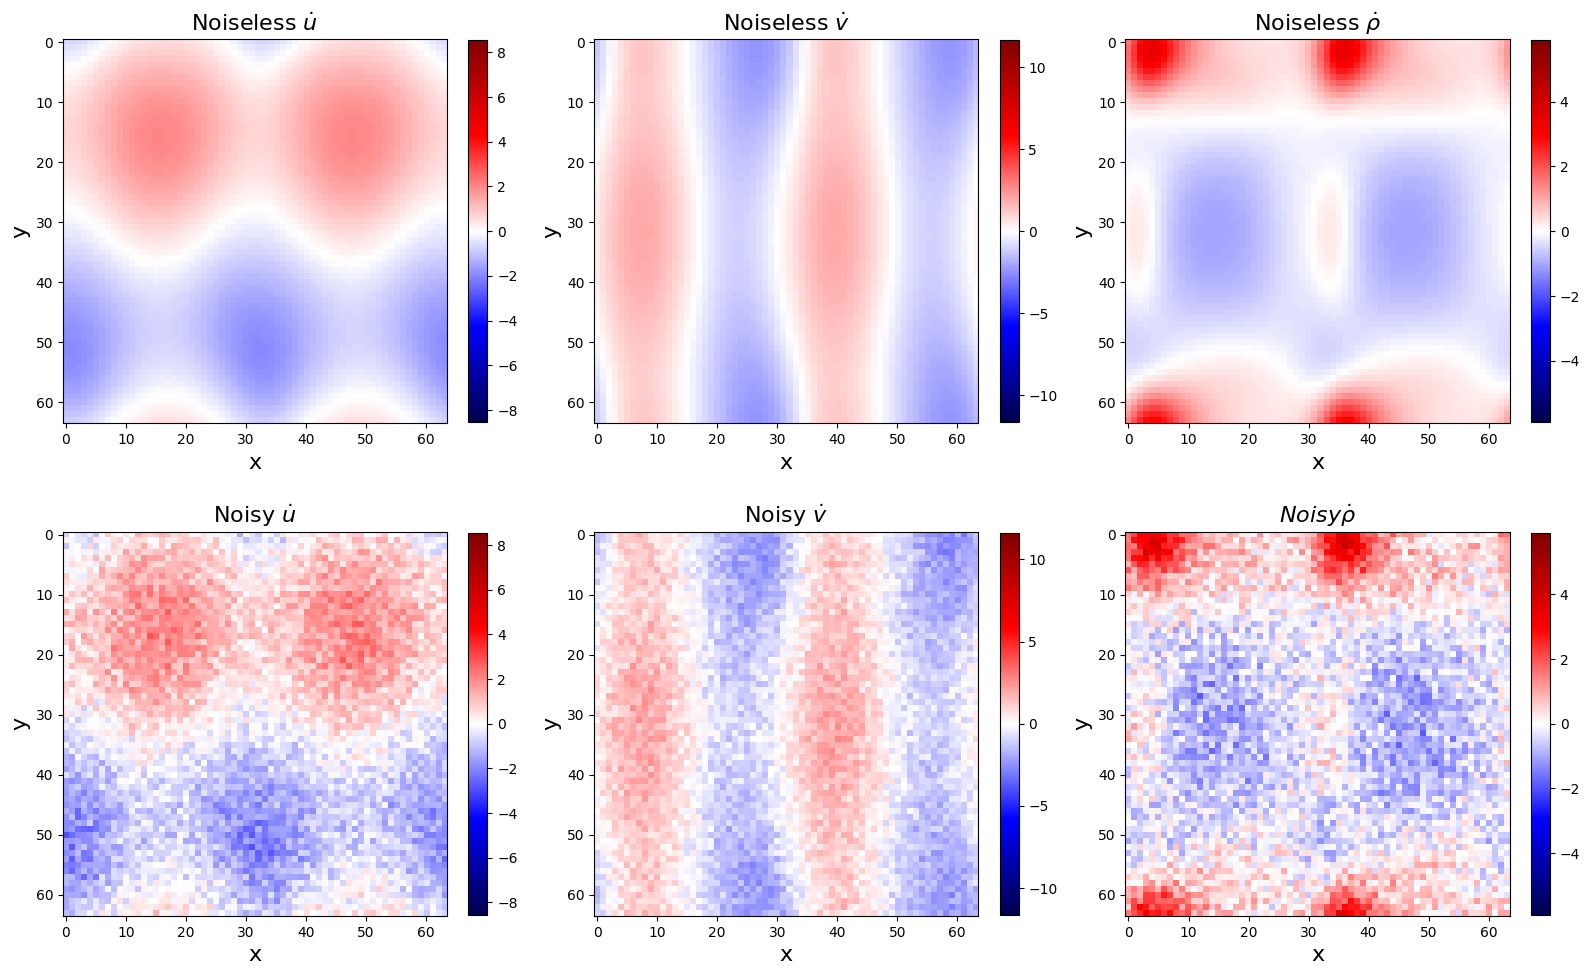

In [16]:
u_shaped_noiseless = sol.y.reshape(N, N, 3, -1).transpose(0, 1, 3, 2)
u_dot_noiseless = ps.FiniteDifference(d=1, axis=2)._differentiate(u_shaped_noiseless, t)

ep = 5e-3
np.random.seed(100)
u_shaped_noisy = u_shaped_noiseless + 2 * ep * (
    0.5 - np.random.random(size=(N, N, Nt, 3))
)
u_dot_noisy = ps.FiniteDifference(d=1, axis=2)._differentiate(u_shaped_noisy, t)

# Plot u and u_dot
plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 1)
plt.imshow(u_dot_noiseless[:, :, Nt // 2, 0], cmap="seismic")
plt.clim(
    -np.max(np.abs(u_dot_noiseless[:, :, :, 0])),
    np.max(np.abs(u_dot_noiseless[:, :, :, 0])),
)
plt.colorbar(fraction=0.045)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.title(r"Noiseless $\dot{u}$", fontsize=16)

plt.subplot(2, 3, 2)
plt.imshow(u_dot_noiseless[:, :, Nt // 2, 1], cmap="seismic")
plt.clim(
    -np.max(np.abs(u_dot_noiseless[:, :, :, 1])),
    np.max(np.abs(u_dot_noiseless[:, :, :, 1])),
)
plt.colorbar(fraction=0.045)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.title(r"Noiseless $\dot{v}$", fontsize=16)

plt.subplot(2, 3, 3)
plt.imshow(u_dot_noiseless[:, :, Nt // 2, 2], cmap="seismic")
plt.clim(
    -np.max(np.abs(u_dot_noiseless[:, :, :, 2])),
    np.max(np.abs(u_dot_noiseless[:, :, :, 2])),
)
plt.colorbar(fraction=0.045)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.title(r"Noiseless $\dot{\rho}$", fontsize=16)

plt.subplot(2, 3, 4)
plt.imshow(u_dot_noisy[:, :, Nt // 2, 0], cmap="seismic")
plt.clim(
    -np.max(np.abs(u_dot_noiseless[:, :, :, 0])),
    np.max(np.abs(u_dot_noiseless[:, :, :, 0])),
)
plt.colorbar(fraction=0.045)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
ax = plt.gca()
plt.title(r"Noisy $\dot{u}$", fontsize=16)

plt.subplot(2, 3, 5)
plt.imshow(u_dot_noisy[:, :, Nt // 2, 1], cmap="seismic")
plt.clim(
    -np.max(np.abs(u_dot_noiseless[:, :, :, 1])),
    np.max(np.abs(u_dot_noiseless[:, :, :, 1])),
)
plt.colorbar(fraction=0.045)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
ax = plt.gca()
plt.title(r"Noisy $\dot{v}$", fontsize=16)

plt.subplot(2, 3, 6)
plt.imshow(u_dot_noisy[:, :, Nt // 2, 2], cmap="seismic")
plt.clim(
    -np.max(np.abs(u_dot_noiseless[:, :, :, 2])),
    np.max(np.abs(u_dot_noiseless[:, :, :, 2])),
)
plt.colorbar(fraction=0.045)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
ax = plt.gca()
plt.title(r"$Noisy \dot{\rho}$", fontsize=16)

plt.tight_layout()
plt.show()

#### Regular PDELibrary fails for noisy data!

In [17]:
%%time
spatial_grid = np.zeros((N, N, 2))
spatial_grid[:, :, 0] = x[:, np.newaxis]
spatial_grid[:, :, 1] = y[np.newaxis, :]

library_functions = [lambda x: x, lambda x: 1 / (1e-6 + abs(x))]
library_function_names = [lambda x: x, lambda x: x + "^-1"]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=spatial_grid,
)

# Fit the clean data (prints the correct model)
optimizer = ps.STLSQ(threshold=5e-1, alpha=1e-10, normalize_columns=False)
model = ps.SINDy(
    feature_library=pde_lib, optimizer=optimizer, feature_names=["u", "v", "p"]
)
model.fit(u_shaped_noiseless, t=t)
print("Noiseless differential fit:")
model.print()
print("R2 score: ", model.score(u_shaped_noiseless, t=t))

# Fit the noisy data (prints a bad model)
optimizer = ps.STLSQ(threshold=5e-1, alpha=1e-10, normalize_columns=False)
model = ps.SINDy(
    feature_library=pde_lib, optimizer=optimizer, feature_names=["u", "v", "p"]
)
model.fit(u_shaped_noisy, t=t)
print("Noisy differential fit:")
model.print()
print("R2 score: ", model.score(u_shaped_noisy, t=t))

Noiseless differential fit:
(u)' = -1.000 vu_2 + 0.998 p^-1u_22 + -1.002 uu_1 + -1.002 p^-1p_1 + 1.000 p^-1u_11
(v)' = -1.002 vv_2 + -1.000 p^-1p_2 + 1.000 p^-1v_22 + -0.997 uv_1 + 0.998 p^-1v_11
(p)' = -0.997 pv_2 + -0.999 vp_2 + -1.000 pu_1 + -0.998 up_1
R2 score:  0.9999402527135505
Noisy differential fit:
(u)' = -1.971 u + -0.899 vu_2 + 0.837 p^-1v_2 + -0.593 uu_1
(v)' = -1.624 v + -4.063 p^-1u_2 + -0.838 vv_2
(p)' = -0.995 pv_2 + -0.997 vp_2 + -0.997 pu_1 + -0.987 up_1
R2 score:  0.8679715521429276
CPU times: user 28.2 s, sys: 3 s, total: 31.2 s
Wall time: 31.2 s


#### WeakPDELibrary works great for noisy data!

In [18]:
%%time
spatiotemporal_grid = np.zeros((N, N, Nt, 3))
spatiotemporal_grid[:, :, :, 0] = x[:, np.newaxis, np.newaxis]
spatiotemporal_grid[:, :, :, 1] = y[np.newaxis, :, np.newaxis]
spatiotemporal_grid[:, :, :, 2] = t[np.newaxis, np.newaxis, :]

library_functions = [lambda x: x, lambda x: 1 / (1e-6 + abs(x))]
library_function_names = [lambda x: x, lambda x: x + "^-1"]
np.random.seed(100)

weak_pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=spatiotemporal_grid,
    K=2000,
    H_xt=[L / 10, L / 10, T / 10],
)

# Fit the clean data
optimizer = ps.STLSQ(threshold=5e-1, alpha=1e-12, normalize_columns=False)
model = ps.SINDy(
    feature_library=weak_pde_lib, optimizer=optimizer, feature_names=["u", "v", "p"]
)
model.fit(u_shaped_noiseless, t=t)
print("Noiseless weak fit:")
model.print()
print("R2 score: ", model.score(u_shaped_noiseless, t=t))

# Fit the noisy data
optimizer = ps.STLSQ(threshold=5e-1, alpha=1e-12, normalize_columns=False)
model = ps.SINDy(
    feature_library=weak_pde_lib, optimizer=optimizer, feature_names=["u", "v", "p"]
)
model.fit(u_shaped_noisy, t=t)
print("Noisy weak fit:")
model.print()
print("R2 score: ", model.score(u_shaped_noisy, t=t))

Noiseless weak fit:
(u)' = -0.995 vu_2 + 1.004 p^-1u_22 + -0.998 uu_1 + -1.001 p^-1p_1 + 1.000 p^-1u_11
(v)' = -1.000 vv_2 + -1.003 p^-1p_2 + 1.002 p^-1v_22 + -0.999 uv_1 + 1.001 p^-1v_11
(p)' = -1.000 pv_2 + -1.000 vp_2 + -1.000 pu_1 + -1.000 up_1
R2 score:  0.9999966260357548
Noisy weak fit:
(u)' = -0.993 vu_2 + 1.005 p^-1u_22 + -0.996 uu_1 + -1.000 p^-1p_1 + 1.000 p^-1u_11
(v)' = -0.999 vv_2 + -1.002 p^-1p_2 + 1.002 p^-1v_22 + -0.997 uv_1 + 1.000 p^-1v_11
(p)' = -1.000 pv_2 + -1.000 vp_2 + -1.000 pu_1 + -0.999 up_1
R2 score:  0.9999260911356073
CPU times: user 40.3 s, sys: 1.66 s, total: 42 s
Wall time: 42 s


# Test weak-formulation PDE functionality on the Kuramoto-Sivashinsky equation
The Kuramoto-Sivashinsky equation is
$u_t = -uu_x - u_{xx} - u_{xxxx}$. We will skip noisy data for now, since we have already illustrated the pitfalls and performance with the weak form. We will revisit noisy data for the 2D reaction-diffusion example.

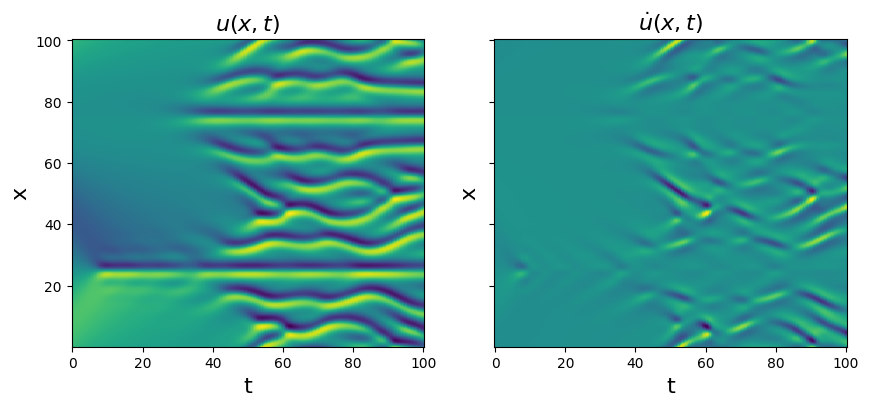

In [13]:
# Load and plot the data
data = loadmat("data/kuramoto_sivishinky.mat")
time = np.ravel(data["tt"])
x = np.ravel(data["x"])
u = data["uu"]
dt = time[1] - time[0]
dx = x[1] - x[0]

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(time, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 2, 2)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$", fontsize=16)
plt.show()

u = u.reshape(len(x), len(time), 1)

In [14]:
# Define weak form PDE library
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
X, T = np.meshgrid(x, time)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=200,
    include_interaction=True,
    periodic=True,
)

In [15]:
%%time
# Run optimizers
optimizer = ps.STLSQ(threshold=0.4, alpha=0.05, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u)
model.print()

optimizer = ps.SR3(
    threshold=0.8, max_iter=1000, thresholder="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u)
print(f"SR3, Threshold: 0.8 :\t ", end="")
model.print()

optimizer = ps.SR3(
    threshold=0.2, max_iter=1000, thresholder="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u)
print(f"SR3, Threshold: 0.2 :\t ", end="")
model.print()

optimizer = ps.SSR(normalize_columns=True, kappa=1e-20, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u)
print(f"SSR, normal :\t ", end="")
model.print()

optimizer = ps.SSR(
    criteria="model_residual", normalize_columns=True, kappa=1e-20, max_iter=20
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u)
print(f"SSR, residual :\t ", end="")
model.print()

optimizer = ps.FROLS(normalize_columns=True, kappa=1e-20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u)
print(f"SSR, FROLS :\t ", end="")
model.print()

(x0)' = -1.000 x0_11 + -1.000 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111
SR3, Threshold: 0.8 :	 (x0)' = -0.998 x0_11 + -1.000 x0_1111 + -1.002 x0x0_1
SR3, Threshold: 0.2 :	 (x0)' = -0.862 x0_11 + -0.864 x0_1111 + -0.932 x0x0_1 + -0.004 x0x0x0_11
SSR, normal :	 (x0)' = -0.999 x0_11 + -1.000 x0_1111 + -1.002 x0x0_1
SSR, residual :	 (x0)' = -0.999 x0_11 + -1.000 x0_1111 + -1.002 x0x0_1
SSR, FROLS :	 (x0)' = -1.000 x0_11 + -1.000 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111
CPU times: user 1.97 s, sys: 4.19 ms, total: 1.98 s
Wall time: 1.97 s


In [17]:
%%time
# Run optimizers
optimizer = ps.STLSQ(threshold=0.4, alpha=0.05, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u)
model.print()

optimizer = ps.SR3(
    threshold=0.8, max_iter=1000, thresholder="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u)
model.print()

optimizer = ps.SR3(
    threshold=0.2, max_iter=1000, thresholder="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u)
model.print()

optimizer = ps.SSR(normalize_columns=True, kappa=1e-20, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u)
model.print()

optimizer = ps.SSR(
    criteria="model_residual", normalize_columns=True, kappa=1e-20, max_iter=20
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u)
model.print()

optimizer = ps.FROLS(normalize_columns=True, kappa=1e-20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u)
model.print()

(x0)' = -1.000 x0_11 + -1.000 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111
(x0)' = -0.998 x0_11 + -1.000 x0_1111 + -1.002 x0x0_1
(x0)' = -0.862 x0_11 + -0.864 x0_1111 + -0.932 x0x0_1 + -0.004 x0x0x0_11
(x0)' = -0.999 x0_11 + -1.000 x0_1111 + -1.002 x0x0_1
(x0)' = -0.999 x0_11 + -1.000 x0_1111 + -1.002 x0x0_1
(x0)' = -1.000 x0_11 + -1.000 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111
CPU times: user 2.17 s, sys: 16 ms, total: 2.18 s
Wall time: 2.18 s


**Okay, so all the optimizers essentially capture the model but often have some much smaller "extra" terms.**
The best way to deal with these spurious terms is to use ensembling, i.e. the generation of many models by sub-sampling the data, or sub-sampling the SINDy candidate library. See notebook 13 for many examples of how to use these methods. 

You can also deal with this by scanning over the hyperparameters for each method although this is more laborious for the user. 

**Next we try the SR3 optimizer on the same data but with added noise of varying levels to illustrate the robustness to noisy data.**
Ideally, we would cross-validate over 10-20 noise instantiations, but with this high-dimensional data this can be computationally slow. We compute the coefficient model errors defined through
$$\Delta\xi_{u_{xx}} = \|\xi_{u_{xx}}^{true} - \xi_{u_{xx}}^{pred}\| / \|\xi_{u_{xx}}^{true}\| =  \|-1 - \xi_{u_{xx}}^{pred}\|,$$
and similarly for the other coefficients.

In [ ]:
%%time
# Get average SR3 performance as function of the noise level.
cross_val_runs = 5
u = np.squeeze(u)
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
noise_levels = np.linspace(0, rmse / 2.0, 5)
delta_c1 = np.zeros((cross_val_runs, len(noise_levels)))
delta_c2 = np.zeros((cross_val_runs, len(noise_levels)))
delta_c3 = np.zeros((cross_val_runs, len(noise_levels)))

# Make a weak form library with high-resolution
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatiotemporal_grid=XT,
    K=400,
    is_uniform=True,
)
# Pick an optimizer with some plausible hyperparameters
optimizer = ps.SR3(threshold=1, max_iter=1000, thresholder="l0", normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# Loop over noisy data and cross-validate
for i in range(cross_val_runs):
    for j, noise in enumerate(noise_levels):
        u_noisy = u + np.random.normal(0, noise, u.shape)
        u_noisy = np.reshape(u_noisy, (len(x), len(time), 1))
        model.fit(u_noisy, quiet=True)
        print(f"SR3, {i = }, {noise = } :\t ", end="")
        model.print()
        c1 = abs(optimizer.coef_[0, 6])
        c2 = abs(optimizer.coef_[0, 3])
        c3 = abs(optimizer.coef_[0, 5])
        delta_c1[i, j] = abs(abs(c1 - 1.0) / c1)
        delta_c2[i, j] = abs(abs(c2 - 1.0) / c2)
        delta_c3[i, j] = abs(abs(c3 - 1.0) / c3)

SR3, i = 0, noise = 0.0 :	 (x0)' = -0.998 x0_11 + -0.999 x0_1111 + -1.002 x0x0_1
SR3, i = 0, noise = 0.12749753081847393 :	 (x0)' = -0.998 x0_11 + -1.000 x0_1111 + -1.002 x0x0_1
SR3, i = 0, noise = 0.25499506163694785 :	 (x0)' = -0.006 x0 + -1.000 x0_11 + -1.003 x0_1111 + -0.999 x0x0_1
SR3, i = 0, noise = 0.3824925924554218 :	 (x0)' = 0.014 x0 + -0.982 x0_11 + -0.986 x0_1111 + -0.997 x0x0_1
SR3, i = 0, noise = 0.5099901232738957 :	 (x0)' = -0.967 x0_11 + -0.965 x0_1111 + -0.997 x0x0_1 + -0.001 x0x0_11
SR3, i = 1, noise = 0.0 :	 (x0)' = -0.998 x0_11 + -0.999 x0_1111 + -1.002 x0x0_1
SR3, i = 1, noise = 0.12749753081847393 :	 (x0)' = -0.995 x0_11 + -0.994 x0_1111 + -1.003 x0x0_1
SR3, i = 1, noise = 0.25499506163694785 :	 (x0)' = -0.979 x0_11 + -0.980 x0_1111 + -0.984 x0x0_1
SR3, i = 1, noise = 0.3824925924554218 :	 (x0)' = -0.999 x0_11 + -0.999 x0_1111 + -0.999 x0x0_1 + 0.001 x0x0x0_11
SR3, i = 1, noise = 0.5099901232738957 :	 (x0)' = 0.009 x0 + 0.003 x0x0 + 0.011 x0_1 + -0.978 x0_11 + -0

In [ ]:
%%time
# Get average SR3 performance as function of the noise level.
cross_val_runs = 1
u = np.squeeze(u)
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
noise_levels = np.linspace(0, rmse / 2.0, 5)
delta_c1 = np.zeros((cross_val_runs, len(noise_levels)))
delta_c2 = np.zeros((cross_val_runs, len(noise_levels)))
delta_c3 = np.zeros((cross_val_runs, len(noise_levels)))

# Make a weak form library with high-resolution
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatiotemporal_grid=XT,
    K=400,
    is_uniform=True,
)
# Pick an optimizer with some plausible hyperparameters
optimizer = ps.SR3(threshold=1, max_iter=1000, thresholder="l0", normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# Loop over noisy data and cross-validate
for i in range(cross_val_runs):
    for j, noise in enumerate(noise_levels):
        u_noisy = u + np.random.normal(0, noise, u.shape)
        u_noisy = np.reshape(u_noisy, (len(x), len(time), 1))
        model.fit(u_noisy, quiet=True)
        model.print()
        c1 = abs(optimizer.coef_[0, 6])
        c2 = abs(optimizer.coef_[0, 3])
        c3 = abs(optimizer.coef_[0, 5])
        delta_c1[i, j] = abs(abs(c1 - 1.0) / c1)
        delta_c2[i, j] = abs(abs(c2 - 1.0) / c2)
        delta_c3[i, j] = abs(abs(c3 - 1.0) / c3)

(x0)' = -0.998 x0_11 + -0.999 x0_1111 + -1.002 x0x0_1
(x0)' = -0.994 x0_11 + -0.994 x0_1111 + -0.999 x0x0_1
(x0)' = 0.006 x0 + -0.995 x0_11 + -0.997 x0_1111 + -1.005 x0x0_1
(x0)' = -0.989 x0_11 + -0.988 x0_1111 + -1.006 x0x0_1 + -0.001 x0x0_11 + -0.001 x0x0x0_11
(x0)' = 0.018 x0 + -0.976 x0_11 + -0.975 x0_1111 + -0.986 x0x0_1 + 0.002 x0x0_11 + 0.001 x0x0x0_11
CPU times: user 4 s, sys: 31.6 ms, total: 4.03 s
Wall time: 4.02 s


Now that we have computed the error in the model coefficients at each noise level, we plot the results.
We show below that the weak form nicely works for even 50% Gaussian noise added to every point, showing the power of the weak-formulation for robust system identification.

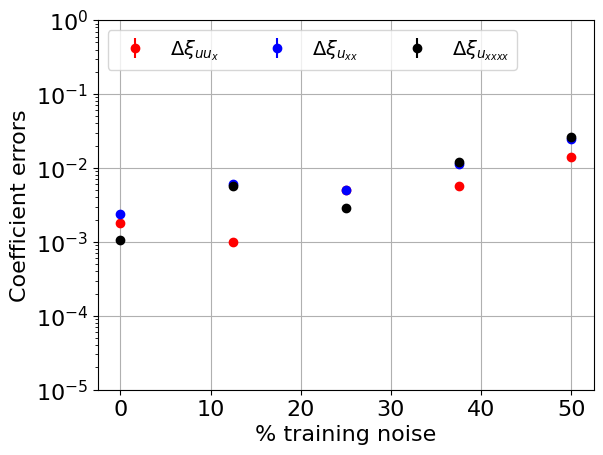

In [ ]:
# Find mean and std over the validation runs
delta_c1_mean = np.nanmean(delta_c1, axis=0)
delta_c2_mean = np.nanmean(delta_c2, axis=0)
delta_c3_mean = np.nanmean(delta_c3, axis=0)

delta_c1_std = np.nanstd(delta_c1, axis=0)
delta_c2_std = np.nanstd(delta_c2, axis=0)
delta_c3_std = np.nanstd(delta_c3, axis=0)

# Plot average and standard deviations of the coefficient errors
plt.figure()
plt.errorbar(
    noise_levels / rmse * 100,
    y=delta_c1_mean,
    yerr=delta_c1_std,
    color="r",
    fmt="o",
    label=r"$\Delta\xi_{uu_x}$",
)
plt.errorbar(
    noise_levels / rmse * 100,
    y=delta_c2_mean,
    yerr=delta_c2_std,
    color="b",
    fmt="o",
    label=r"$\Delta\xi_{u_{xx}}$",
)
plt.errorbar(
    noise_levels / rmse * 100,
    y=delta_c3_mean,
    yerr=delta_c3_std,
    color="k",
    fmt="o",
    label=r"$\Delta\xi_{u_{xxxx}}$",
)
plt.yscale("log")
plt.legend(fontsize=14, loc="upper left", ncol=3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
ax = plt.gca()
ax.set_ylim(1e-5, 1)
plt.xlabel("% training noise", fontsize=16)
plt.ylabel("Coefficient errors", fontsize=16)
plt.savefig("SR3_weakformPDE_KS.png")

# Test weak form PDE functionality on Reaction-Diffusion system
We now demonstrate another more advanced example - using the weak formulation of SINDy to robustly identify a 2D PDE.
This 2D system is significantly more complicated. The reaction-diffusion system exhibits spiral waves on a periodic domain,and the PDEs are:
$$u_t = 0.1\nabla^2 u + (1-A^2)u +\beta A^2v$$
$$v_t = 0.1\nabla^2 v - \beta A^2 u + (1-A^2)v$$
$$A^2 = u^2 + v^2.$$
The main change will be a significantly larger library... cubic terms in (u, v) and all their first and second order derivatives. We will also need to generate the data because saving a high-resolution form of the data makes a fairly large file. See the Example 10 Jupyter notebook for the non-weak-form system identification of the reaction-diffusion system.

Note that the Rudy PDE-FIND paper and Messenger Weak SINDy paper use 256 spatial points in each spatial direction, but Reinbold weak SINDy PRE paper uses 512 points in each direction. We will try and get away with only 64 points in each direction for speed (with normal PDE-FIND this would be a liability because the high order derivatives are very noisy), and still show robustness to ~ 10% noise levels

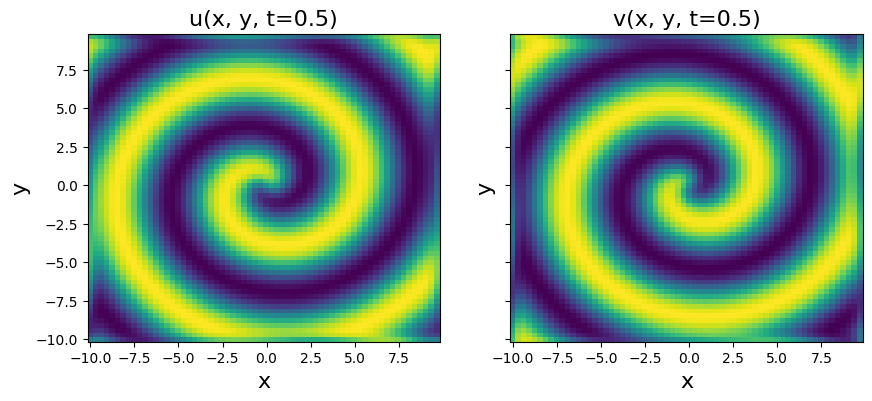

In [25]:
from numpy.fft import fft2, ifft2


# Define the reaction-diffusion PDE in the Fourier (kx, ky) space
def reaction_diffusion(t, uvt, K22, d1, d2, beta, n, N):
    ut = np.reshape(uvt[:N], (n, n))
    vt = np.reshape(uvt[N : 2 * N], (n, n))
    u = np.real(ifft2(ut))
    v = np.real(ifft2(vt))
    u3 = u**3
    v3 = v**3
    u2v = (u**2) * v
    uv2 = u * (v**2)
    utrhs = np.reshape((fft2(u - u3 - uv2 + beta * u2v + beta * v3)), (N, 1))
    vtrhs = np.reshape((fft2(v - u2v - v3 - beta * u3 - beta * uv2)), (N, 1))
    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(
        np.vstack(
            (-d1 * K22 * uvt_reshaped[:N] + utrhs, -d2 * K22 * uvt_reshaped[N:] + vtrhs)
        )
    )
    return uvt_updated


# Generate the data
t = np.linspace(0, 10, int(10 / 0.1))
d1 = 0.1
d2 = 0.1
beta = 1.0
L = 20  # Domain size in X and Y directions
n = 64  # Number of spatial points in each direction
N = n * n
x_uniform = np.linspace(-L / 2, L / 2, n + 1)
x = x_uniform[:n]
y = x_uniform[:n]
n2 = int(n / 2)
# Define Fourier wavevectors (kx, ky)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2), np.linspace(-n2, -1, n2)))
ky = kx
# Get 2D meshes in (x, y) and (kx, ky)
X, Y = np.meshgrid(x, y)
KX, KY = np.meshgrid(kx, ky)
K2 = KX**2 + KY**2
K22 = np.reshape(K2, (N, 1))

m = 1  # number of spirals

# define our solution vectors
u = np.zeros((len(x), len(y), len(t)))
v = np.zeros((len(x), len(y), len(t)))

# Initial conditions
u[:, :, 0] = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(
    m * np.angle(X + 1j * Y) - (np.sqrt(X**2 + Y**2))
)
v[:, :, 0] = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(
    m * np.angle(X + 1j * Y) - (np.sqrt(X**2 + Y**2))
)

# uvt is the solution vector in Fourier space, so below
# we are initializing the 2D FFT of the initial condition, uvt0
uvt0 = np.squeeze(
    np.hstack(
        (np.reshape(fft2(u[:, :, 0]), (1, N)), np.reshape(fft2(v[:, :, 0]), (1, N)))
    )
)

# Solve the PDE in the Fourier space, where it reduces to system of ODEs
uvsol = solve_ivp(
    reaction_diffusion, (t[0], t[-1]), y0=uvt0, t_eval=t, args=(K22, d1, d2, beta, n, N)
)
uvsol = uvsol.y

# Reshape things and ifft back into (x, y, t) space from (kx, ky, t) space
for j in range(len(t)):
    ut = np.reshape(uvsol[:N, j], (n, n))
    vt = np.reshape(uvsol[N:, j], (n, n))
    u[:, :, j] = np.real(ifft2(ut))
    v[:, :, j] = np.real(ifft2(vt))

# Plot to check if spiral is nicely reproduced
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X, Y, u[:, :, 10])
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.title("u(x, y, t=0.5)", fontsize=16)
plt.subplot(1, 2, 2)
plt.pcolor(X, Y, v[:, :, 10])
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title("v(x, y, t=0.5)", fontsize=16)

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

u_sol = u
v_sol = v

In [26]:
u = np.zeros((n, n, len(t), 2))
u[:, :, :, 0] = u_sol
u[:, :, :, 1] = v_sol

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]

np.random.seed(100)
# Need to define the 2D spatial grid before calling the library
X, Y, T = np.meshgrid(x, y, t, indexing="ij")
XYT = np.transpose([X, Y, T], [1, 2, 3, 0])
weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XYT,
    is_uniform=True,
    periodic=True,
    K=100,
    include_interaction=False,
)

In [27]:
%%time
# Fit the 2D reaction-diffusion equation, weak form style!
optimizer = ps.STLSQ(threshold=0.05, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer)
model.fit(u, quiet=True)
model.print()

TypeError: SINDy.fit() got an unexpected keyword argument 'quiet'

Okay, so we have captured the terms in the clean data case... can we repeat with some added noise?

In [ ]:
%time
# Need to increase the weak form mesh resolution a bit if data is noisy
weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XYT,
    K=1000,
    is_uniform=True,
    periodic=True,
    include_interaction=True,
)

# Initialize noisy data
rmse = mean_squared_error(u.flatten(), np.zeros(u.size), squared=False)
u_noisy = u + np.random.normal(0, rmse / 50.0, u.shape)  # Add 2% noise

# Fit the 2D reaction-diffusion equation with noise, weak form style!
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer)
model.fit(u_noisy, quiet=True)
model.print()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
(x0)' = 0.844 x0 + 0.204 x1 + -0.844 x0x0x0 + 0.775 x1x1x1 + -0.846 x0x1x1 + 0.774 x0x0x1 + 0.084 x0_22 + 0.084 x0_11
(x1)' = -0.135 x0 + 0.862 x1 + -0.851 x0x0x0 + -0.862 x1x1x1 + -0.851 x0x1x1 + -0.862 x0x0x1 + 0.086 x1_22 + 0.085 x1_11


The weak formulation works adequately with noise, but requires a relatively large K. *How is this adequate?*

# Test weak form PDE functionality on 3D Reaction-Diffusion system
Can even use weak-form for 3D PDEs although this is getting computationally intensive! 

We will use a 3D reaction-diffusion equation called the Gray-Scott Equation. We are folllowing the example in Section 3.3.3 of Maddu, S., Cheeseman, B. L., Sbalzarini, I. F., & Müller, C. L. (2019). Stability selection enables robust learning of partial differential equations from limited noisy data. arXiv preprint arXiv:1907.07810. ([Link](https://arxiv.org/pdf/1907.07810.pdf)).
$$u_t = D_u\nabla^2 u - uv^2 + 0.014(1-u)$$
$$v_t = D_v\nabla^2 v + uv^2 - 0.067 v$$
We will need to generate some low-resolution data, because the memory requirements are very significant for a fully 3D problem. We can still get a pretty good model.

CPU times: user 10.1 s, sys: 80 ms, total: 10.2 s
Wall time: 10.2 s


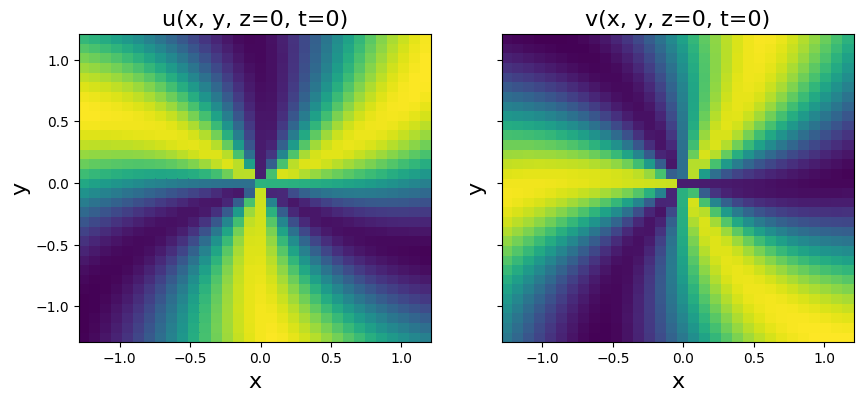

In [28]:
%%time
from numpy.fft import fftn, ifftn


# Define the reaction-diffusion PDE in the Fourier (kx, ky, kz) space
def reaction_diffusion(t, uvt, K22, d1, d2, n, N):
    ut = np.reshape(uvt[:N], (n, n, n))
    vt = np.reshape(uvt[N : 2 * N], (n, n, n))
    u = np.real(ifftn(ut, axes=[0, 1, 2]))
    v = np.real(ifftn(vt, axes=[0, 1, 2]))
    uv2 = u * (v**2)
    utrhs = np.reshape((fftn(0.014 * (1 - u) - uv2, axes=[0, 1, 2])), (N, 1))
    vtrhs = np.reshape((fftn(uv2 - 0.067 * v, axes=[0, 1, 2])), (N, 1))
    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(
        np.vstack(
            (-d1 * K22 * uvt_reshaped[:N] + utrhs, -d2 * K22 * uvt_reshaped[N:] + vtrhs)
        )
    )
    return uvt_updated


# Generate the data
dt = 0.1
t = np.linspace(0, 10, int(10 / dt))
d1 = 2e-2
d2 = 1e-2
L = 2.5  # Domain size in X, Y, Z directions
n = 32  # Number of spatial points in each direction
N = n * n * n
x_uniform = np.linspace(-L / 2, L / 2, n + 1)
x = x_uniform[:n]
y = x_uniform[:n]
z = x_uniform[:n]
n2 = int(n / 2)
# Define Fourier wavevectors (kx, ky, kz)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2), np.linspace(-n2, -1, n2)))
ky = kx
kz = kx
# Get 3D meshes in (x, y, z) and (kx, ky, kz)
X, Y, Z = np.meshgrid(x, y, z, indexing="ij")
KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing="ij")
K2 = KX**2 + KY**2 + KZ**2
K22 = np.reshape(K2, (N, 1))

m = 3  # number of spirals

# define our solution vectors
u = np.zeros((n, n, n, len(t)))
v = np.zeros((n, n, n, len(t)))

# Initial conditions
u[:, :, :, 0] = np.tanh(np.sqrt(X**2 + Y**2 + Z**2)) * np.cos(
    m * np.angle(X + 1j * Y) - (np.sqrt(X**2 + Y**2 + Z**2))
)
v[:, :, :, 0] = np.tanh(np.sqrt(X**2 + Y**2 + Z**2)) * np.sin(
    m * np.angle(X + 1j * Y) - (np.sqrt(X**2 + Y**2 + Z**2))
)

# uvt is the solution vector in Fourier space, so below
# we are initializing the 2D FFT of the initial condition, uvt0
uvt0 = np.squeeze(
    np.hstack(
        (
            np.reshape(fftn(u[:, :, :, 0], axes=[0, 1, 2]), (1, N)),
            np.reshape(fftn(v[:, :, :, 0], axes=[0, 1, 2]), (1, N)),
        )
    )
)

# Solve the PDE in the Fourier space, where it reduces to system of ODEs
uvsol = solve_ivp(
    reaction_diffusion, (t[0], t[-1]), y0=uvt0, t_eval=t, args=(K22, d1, d2, n, N)
)
uvsol = uvsol.y

# Reshape things and ifft back into (x, y, z, t) space from (kx, ky, kz, t) space
for j in range(len(t)):
    ut = np.reshape(uvsol[:N, j], (n, n, n))
    vt = np.reshape(uvsol[N:, j], (n, n, n))
    u[:, :, :, j] = np.real(ifftn(ut, axes=[0, 1, 2]))
    v[:, :, :, j] = np.real(ifftn(vt, axes=[0, 1, 2]))

# Plot to check if spiral is nicely reproduced
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X[:, :, 0], Y[:, :, 0], u[:, :, 0, 0])
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.title("u(x, y, z=0, t=0)", fontsize=16)
plt.subplot(1, 2, 2)
plt.pcolor(X[:, :, 0], Y[:, :, 0], v[:, :, 0, 0])
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title("v(x, y, z=0, t=0)", fontsize=16)

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]

u_sol = u
v_sol = v

In [29]:
time = t
u = np.zeros((n, n, n, len(time), 2))
u[:, :, :, :, 0] = u_sol
u[:, :, :, :, 1] = v_sol
u_dot = ps.FiniteDifference(axis=3)._differentiate(u, dt)

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]

# Need to define the 2D spatial grid before calling the library
X, Y, Z, T = np.meshgrid(x, y, z, time, indexing="ij")
spatiotemporal_grid = np.asarray([X, Y, Z, T])
spatiotemporal_grid = np.transpose(spatiotemporal_grid, axes=[1, 2, 3, 4, 0])
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=spatiotemporal_grid,
    is_uniform=True,
    include_interaction=False,
    include_bias=True,
    periodic=True,
    K=2000,
)

In [31]:
%%time
# Fit the 3D reaction-diffusion equation
optimizer = ps.SR3(threshold=1e-5, normalize_columns=True, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u)
model.print()

(x0)' = 0.014 1 + -0.021 x0 + -0.993 x0x1x1 + 0.018 x0_33 + 0.016 x0_22 + 0.016 x0_11
(x1)' = -0.072 x1 + 0.989 x0x1x1 + 0.008 x1_33 + 0.008 x1_22 + 0.008 x1_11
CPU times: user 1.34 s, sys: 56 ms, total: 1.4 s
Wall time: 1.39 s


Correct equations are:
$$u_t = 0.02\nabla^2 u - uv^2 + 0.014(1-u)$$
$$v_t = 0.01\nabla^2 v + uv^2 - 0.067 v$$
So our model is pretty good!